In [1]:
library("ggplot2")
library("ggpubr")

library("matrixStats")# colMeans
source("analysis.utils.r")
source("simulate.expression.utils.r")

set.seed(2023)

Warning message:
“package ‘MASS’ was built under R version 4.1.3”
Welcome to compositions, a package for compositional data analysis.
Find an intro with "? compositions"



Attaching package: ‘compositions’


The following objects are masked from ‘package:stats’:

    anova, cor, cov, dist, var


The following objects are masked from ‘package:base’:

    %*%, norm, scale, scale.default




In [2]:
#data.name = "PBMC"
data.name = "Lung"

# source.col = "decon.L2" 
# N = 500

# source.col = "decon.L1" 
# N = 500

# source.col = "decon.L1" 
# N = 250

source.col = "decon.L1" 
N = 100

In [3]:
max_stds = 2
ts = 1:20

project.dir = "/u/home/j/johnsonc/project-halperin/TCAx/TCAx2023/"

#relative path of the data dir to project.dir
if(data.name == "PBMC"){
    if(source.col == "decon.L1"){
        data.dir = paste0("Data/RNA/Simulation-PBMC/sc-Stephenson_all.W_decon.L1_HEF.10k_k_5_m_600_n_", N, "_dirichlet_F_noiseZ_T_varThr_1e-04_filThr_1e-04_expQtl_0_enrich_F_etpRat_0_enrichRat_0_maxSds_", max_stds, "_scale.maxSds_Inf_scale.factor.thr_1e-04/")
        figure.dir  = paste0("Figure/Simulation-PBMC/decon.L1.max_stds.",max_stds)
    }else{
        data.dir = paste0("Data/RNA/Simulation-PBMC/sc-Stephenson_all.W_decon.L2_HEF.10k_k_7_m_600_n_", N, "_dirichlet_F_noiseZ_T_varThr_1e-04_filThr_1e-04_expQtl_0_enrich_F_etpRat_0_enrichRat_0_maxSds_", max_stds, "_scale.maxSds_Inf_scale.factor.thr_1e-04/")
        figure.dir  = paste0("Figure/Simulation-PBMC/decon.L2.max_stds.",max_stds)
    }
}else{
    if(source.col == "decon.L1"){
        data.dir = paste0("Data/RNA/Simulation-Lung/sc-HLCA_all.W_decon.L1_HEF.10k_k_4_m_600_n_", N, "_dirichlet_F_noiseZ_T_varThr_1e-04_filThr_1e-04_expQtl_0_enrich_F_etpRat_0_enrichRat_0_maxSds_", max_stds, "_scale.maxSds_Inf_scale.factor.thr_1e-04/")
        figure.dir  = paste0("Figure/Simulation-Lung/decon.L1.max_stds.",max_stds)
    }else{
        data.dir = paste0("Data/RNA/Simulation-Lung/sc-HLCA_all.W_decon.L2_HEF.10k_k_6_m_600_n_", N, "_dirichlet_F_noiseZ_T_varThr_1e-04_filThr_1e-04_expQtl_0_enrich_F_etpRat_0_enrichRat_0_maxSds_", max_stds, "_scale.maxSds_Inf_scale.factor.thr_1e-04/")
        figure.dir  = paste0("Figure/Simulation-Lung/decon.L2.max_stds.",max_stds)
    }

}

In [4]:
data.dir   = file.path(project.dir, data.dir)
figure.dir = file.path(project.dir, figure.dir)
data.dir.split  = strsplit(data.dir, "/")[[1]]
res.dir    = file.path(project.dir, paste(c("Result", data.dir.split[(length(data.dir.split)-2) : length(data.dir.split)]), collapse = "/"))

if (!file.exists(res.dir)){print("no result in the result directory")}
if (!file.exists(figure.dir)) {dir.create(figure.dir, recursive = T)}
print(data.dir)
print(res.dir)
print(figure.dir)

[1] "/u/home/j/johnsonc/project-halperin/TCAx/TCAx2023//Data/RNA/Simulation-Lung/sc-HLCA_all.W_decon.L1_HEF.10k_k_4_m_600_n_100_dirichlet_F_noiseZ_T_varThr_1e-04_filThr_1e-04_expQtl_0_enrich_F_etpRat_0_enrichRat_0_maxSds_2_scale.maxSds_Inf_scale.factor.thr_1e-04/"
[1] "/u/home/j/johnsonc/project-halperin/TCAx/TCAx2023//Result/RNA/Simulation-Lung/sc-HLCA_all.W_decon.L1_HEF.10k_k_4_m_600_n_100_dirichlet_F_noiseZ_T_varThr_1e-04_filThr_1e-04_expQtl_0_enrich_F_etpRat_0_enrichRat_0_maxSds_2_scale.maxSds_Inf_scale.factor.thr_1e-04"
[1] "/u/home/j/johnsonc/project-halperin/TCAx/TCAx2023//Figure/Simulation-Lung/decon.L1.max_stds.2"


# load Simluation data and result

In [5]:
sim.data.list = readRDS(file.path(data.dir, "sim.data.list.rds"))

# load models
tca.mdl.list  = readRDS(file.path(res.dir, paste0("tca.mdl.list.rds")))
base.mdl.list = readRDS(file.path(res.dir, paste0("base.mdl.list.rds")))
cibersortx.mdl.list = readRDS(file.path(res.dir, paste0("cibersortx.mdl.list.rds")))

bMIND.mdl.list = readRDS(file.path(res.dir, paste0("bMIND.mdl.rough.prior.list.rds")))


## load TCAx
mean_penalty  = 0
var_penalty   = 0.01
covar_penalty = 0.01

pen.config = paste("mp", mean_penalty, "vp", var_penalty, "cp", covar_penalty, "maxStds", max_stds, sep =  "_")
print(pen.config)

tcax.mdl.list = readRDS(file.path(res.dir, paste0("tcax.mdl.", pen.config, ".list.rds")))

[1] "mp_0_vp_0.01_cp_0.01_maxStds_2"


# shared across figures

In [6]:
if (source.col == "decon.L1"){
    title.size = 20
    lab.size = 20
    legend.size = 20  
}else{
    title.size = 17.5
    lab.size = 17.5
    legend.size = 20    
}


source.ids = colnames(sim.data.list[[1]]$W)
print(source.ids)
k = length(source.ids)
m = nrow(sim.data.list[[1]]$X)
n = ncol(sim.data.list[[1]]$X)

[1] "Immune"      "Epithelial"  "Endothelial" "Stroma"     


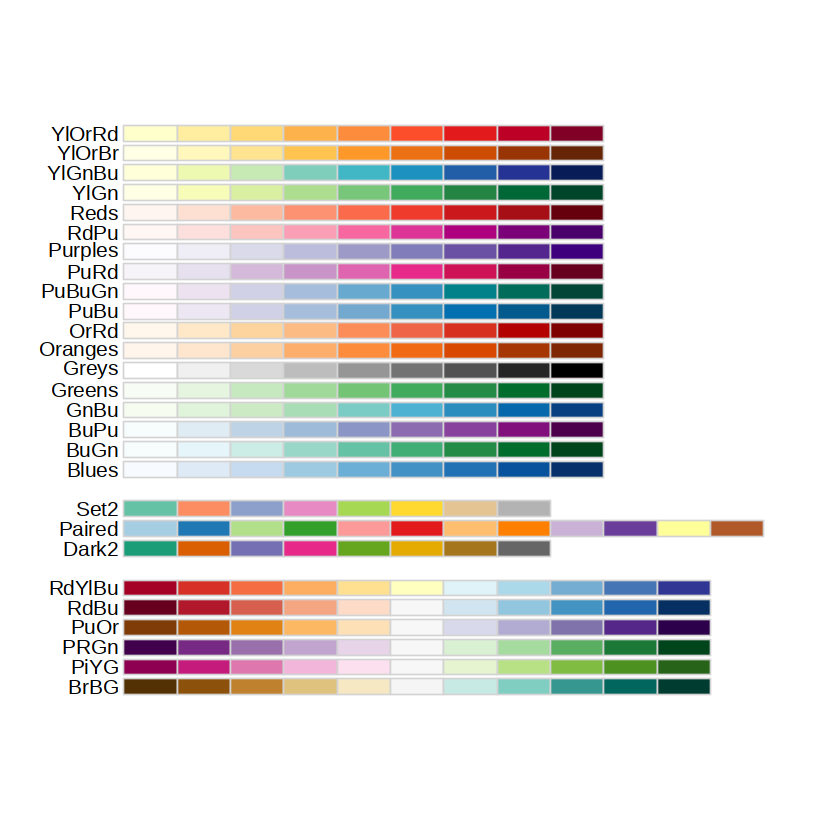

In [7]:
library(RColorBrewer)
display.brewer.all(colorblindFriendly = TRUE)

In [8]:
base.color       = brewer.pal(n = 8, name = "Set2")[8]
cibersortx.color = brewer.pal(n = 8, name = "Set2")[5]
tcax.color       = brewer.pal(n = 8, name = "Set2")[4]
tca.color        = brewer.pal(n = 8, name = "Set2")[6]
bMIND.color      = brewer.pal(n = 8, name = "Set2")[3] 

In [9]:
#keys are the method
#per key a matrix, rows are the runs
mus.corrs.list = list(
    Baseline   = concat_2_keys(base.mdl.list,       key1 ="moment.recon.corrs", key2 = "mus.rob.corrs"),                
    CIBERSORTx = concat_2_keys(cibersortx.mdl.list, key1 ="moment.recon.corrs", key2 = "mus.rob.corrs"),                    
    TCA        = concat_2_keys(tca.mdl.list,        key1 ="moment.hat.corrs",   key2 = "mus.rob.corrs"),                     
    TCAx       = concat_2_keys(tcax.mdl.list,       key1 ="moment.hat.corrs",   key2 = "mus.rob.corrs"),
    bMIND      = concat_2_keys(bMIND.mdl.list,      key1 ="moment.hat.corrs",   key2 = "mus.rob.corrs")
)
var.corrs.list = list(
    Baseline   = concat_2_keys(base.mdl.list,       key1 ="moment.recon.corrs", key2 = "var.rob.corrs"),                
    CIBERSORTx = concat_2_keys(cibersortx.mdl.list, key1 ="moment.recon.corrs", key2 = "var.rob.corrs"),                    
    TCA        = concat_2_keys(tca.mdl.list,        key1 ="moment.hat.corrs",   key2 = "var.rob.corrs"),                     
    TCAx       = concat_2_keys(tcax.mdl.list,       key1 ="moment.hat.corrs",   key2 = "var.rob.corrs"),
    bMIND      = concat_2_keys(bMIND.mdl.list,      key1 ="moment.hat.corrs",   key2 = "var.rob.corrs")
)
covar.corrs.list = list(
    Baseline   = concat_2_keys(base.mdl.list,       key1 ="moment.recon.corrs", key2 = "covar.rob.corrs"),                
    CIBERSORTx = concat_2_keys(cibersortx.mdl.list, key1 ="moment.recon.corrs", key2 = "covar.rob.corrs"),                    
    TCA        = concat_2_keys(tca.mdl.list,        key1 ="moment.recon.corrs", key2 = "covar.rob.corrs"),                     
    TCAx       = concat_2_keys(tcax.mdl.list,       key1 ="moment.hat.corrs",   key2 = "covar.rob.corrs"),
    bMIND      = concat_2_keys(bMIND.mdl.list,      key1 ="moment.hat.corrs",   key2 = "covar.rob.corrs")
)
covar.ids = colnames(covar.corrs.list[[1]])

methods = c("Baseline", "CIBERSORTx", "TCA", "bMIND", "TCAx")
method.colors = c(base.color, cibersortx.color , tca.color, bMIND.color, tcax.color)

# parameters: Mean barplots

In [10]:
mean.barplot.df = data.frame(
    method = as.vector(vapply(1:length(methods), function(a) rep(methods[a], k), character(k))),
    source = as.vector(rep(source.ids, length(methods))),
    mean   = as.vector(vapply(1:length(methods), function(a) colMeans(mus.corrs.list[[methods[a]]]), numeric(k))),
    lb_sd  = as.vector(vapply(1:length(methods), function(a) colMeans(mus.corrs.list[[methods[a]]]) - colSds(mus.corrs.list[[methods[a]]]),  numeric(k))),
    ub_sd  = as.vector(vapply(1:length(methods), function(a) colMeans(mus.corrs.list[[methods[a]]]) + colSds(mus.corrs.list[[methods[a]]]),  numeric(k)))
)

# set some to factors so that the figures respect the order 
mean.barplot.df$source = factor(mean.barplot.df$source, levels = source.ids)
mean.barplot.df$method = factor(mean.barplot.df$method, levels = methods)
levels(mean.barplot.df$method)[match("TCAx",levels(mean.barplot.df$method))] <- "Unico"

In [11]:
str(mus.corrs.list)

List of 5
 $ Baseline  : num [1:20, 1:4] 0.964 0.952 0.953 0.947 0.969 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:20] "mus.rob.corrs" "mus.rob.corrs" "mus.rob.corrs" "mus.rob.corrs" ...
  .. ..$ : chr [1:4] "Immune" "Epithelial" "Endothelial" "Stroma"
 $ CIBERSORTx: num [1:20, 1:4] 0.967 0.948 0.96 0.953 0.965 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:20] "mus.rob.corrs" "mus.rob.corrs" "mus.rob.corrs" "mus.rob.corrs" ...
  .. ..$ : chr [1:4] "Immune" "Epithelial" "Endothelial" "Stroma"
 $ TCA       : num [1:20, 1:4] 0.99 0.973 0.989 0.983 0.987 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:20] "mus.rob.corrs" "mus.rob.corrs" "mus.rob.corrs" "mus.rob.corrs" ...
  .. ..$ : chr [1:4] "Immune" "Epithelial" "Endothelial" "Stroma"
 $ TCAx      : num [1:20, 1:4] 0.992 0.985 0.989 0.985 0.99 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:20] "mus.rob.corrs" "mus.rob.corrs" "mus.rob.corrs" "mus.rob.corrs" ...
  .. ..$ : chr [1:4] "Immune" "

In [12]:
head(mean.barplot.df)

method     source      mean      lb_sd     ub_sd    
1 Baseline   Immune      0.9605763 0.9546119 0.9665408
2 Baseline   Epithelial  0.7847218 0.7520905 0.8173531
3 Baseline   Endothelial 0.7425795 0.7011735 0.7839855
4 Baseline   Stroma      0.7209306 0.6930595 0.7488017
5 CIBERSORTx Immune      0.9613124 0.9522375 0.9703874
6 CIBERSORTx Epithelial  0.8765289 0.8479264 0.9051313

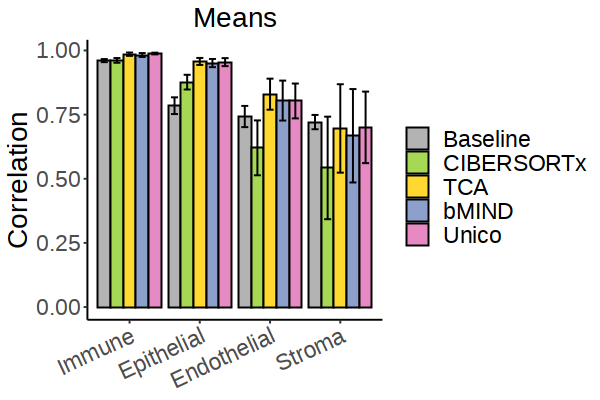

In [13]:
mean.bar.g = ggplot(mean.barplot.df, aes(x=as.factor(source), y=mean, fill=method)) +
             geom_bar(position=position_dodge(.9), stat="identity", colour='black') + 
             geom_errorbar(aes(ymin = lb_sd, ymax= ub_sd), width=.5, position=position_dodge(.9)) +
             scale_fill_manual(values = method.colors) + 
             coord_cartesian(ylim = c(0, max(mean.barplot.df$ub_sd))) +  
             ggtitle("Means") + 
             xlab(paste0("Cell Types")) + 
             ylab(paste0("Correlation")) + 
             theme_classic() +  
             theme(plot.title = element_text(hjust = 0.5, size = title.size),
                   text=element_text(size=lab.size), #text size
                   axis.text.x = element_text(angle = 25, vjust = 1, hjust = 1), #rotate
                   axis.title.x=element_blank(), # no x tilte
                   legend.title = element_blank())
 


options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 100)
mean.bar.g

# parameters: variance barplots

In [14]:
var.barplot.df = data.frame(
    method = as.vector(vapply(1:length(methods), function(a) rep(methods[a], k), character(k))),
    source = as.vector(rep(source.ids, length(methods))),
    mean   = as.vector(vapply(1:length(methods), function(a) colMeans(var.corrs.list[[methods[a]]]), numeric(k))),
    lb_sd  = as.vector(vapply(1:length(methods), function(a) colMeans(var.corrs.list[[methods[a]]]) - colSds(var.corrs.list[[methods[a]]]),    numeric(k))),
    ub_sd  = as.vector(vapply(1:length(methods), function(a) colMeans(var.corrs.list[[methods[a]]]) + colSds(var.corrs.list[[methods[a]]]),    numeric(k)))
)

# set some to factors so that the figures respect the order 
var.barplot.df$source = factor(var.barplot.df$source, levels = source.ids)
var.barplot.df$method = factor(var.barplot.df$method, levels = methods)  
levels(var.barplot.df$method)[match("TCAx",levels(var.barplot.df$method))] <- "Unico"

In [15]:
head(var.barplot.df)

method     source      mean      lb_sd     ub_sd    
1 Baseline   Immune      0.7133175 0.6651982 0.7614368
2 Baseline   Epithelial  0.4836202 0.4104775 0.5567629
3 Baseline   Endothelial 0.4894227 0.4197465 0.5590989
4 Baseline   Stroma      0.3628081 0.2486309 0.4769854
5 CIBERSORTx Immune      0.7441955 0.6979359 0.7904551
6 CIBERSORTx Epithelial  0.5043595 0.4305655 0.5781536

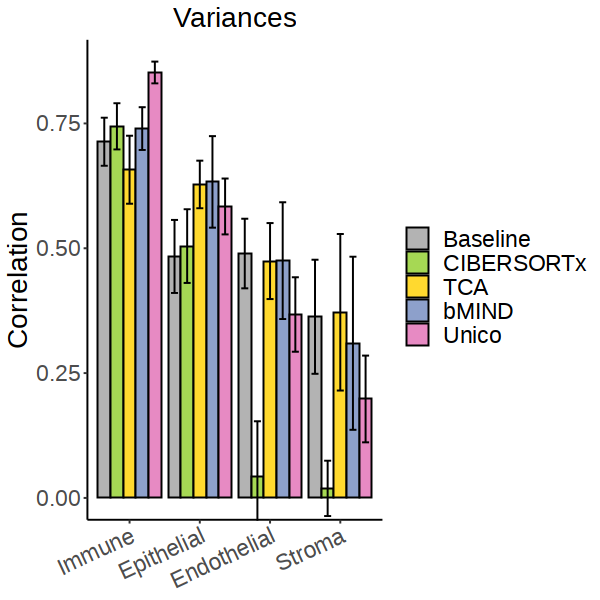

In [16]:
var.bar.g = ggplot(var.barplot.df, aes(x=as.factor(source), y=mean, fill=method)) +
            geom_bar(position=position_dodge(.9), stat="identity", colour='black') + 
            geom_errorbar(aes(ymin = lb_sd, ymax= ub_sd), width=.5, position=position_dodge(.9)) +  
            coord_cartesian(ylim = c(0, max(var.barplot.df$ub_sd))) + 
            scale_fill_manual(values = method.colors) + 
            ggtitle("Variances") + 
            xlab(paste0("Cell Types")) + 
            ylab(paste0("Correlation")) + 
            theme_classic() + 
            theme(plot.title = element_text(hjust = 0.5, size = title.size),
                   text=element_text(size=lab.size), #text size
                   axis.text.x = element_text(angle = 25, vjust = 1, hjust = 1), #rotate
                   axis.title.x=element_blank(), # no x tilte
                   legend.title = element_blank())
 
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 100)
var.bar.g

# parameters: covariance barplots

In [17]:
covar.barplot.df = data.frame(
    method = as.vector(vapply(1:length(methods), function(a) rep(methods[a], length(covar.ids)), character(length(covar.ids)))),
    source = as.vector(rep(covar.ids, length(methods))),
    mean   = as.vector(vapply(1:length(methods), function(a) colMeans(covar.corrs.list[[methods[a]]]), numeric(length(covar.ids)))),
    lb_sd  = as.vector(vapply(1:length(methods), function(a) colMeans(covar.corrs.list[[methods[a]]]) - colSds(covar.corrs.list[[methods[a]]]),    numeric(length(covar.ids)))),
    ub_sd  = as.vector(vapply(1:length(methods), function(a) colMeans(covar.corrs.list[[methods[a]]]) + colSds(covar.corrs.list[[methods[a]]]),    numeric(length(covar.ids))))
)

# extract top TCA perform
covar.ids = covar.ids[order(-covar.barplot.df[covar.barplot.df["method"] == "bMIND","mean"])]
                       
# set some to factors so that the figures respect the order 
covar.barplot.df$source = factor(covar.barplot.df$source, levels = covar.ids)
covar.barplot.df$method = factor(covar.barplot.df$method, levels = methods)     
levels(covar.barplot.df$method)[match("TCAx",levels(covar.barplot.df$method))] <- "Unico"

In [18]:
head(covar.barplot.df)

method   source                 mean        lb_sd       ub_sd     
1 Baseline Immune-Epithelial      -0.30518467 -0.41284738 -0.1975220
2 Baseline Immune-Endothelial      0.32634866  0.16155330  0.4911440
3 Baseline Immune-Stroma           0.26855145  0.13735492  0.3997480
4 Baseline Epithelial-Endothelial -0.01619050 -0.24146964  0.2090886
5 Baseline Epithelial-Stroma       0.07118954 -0.09042521  0.2328043
6 Baseline Endothelial-Stroma      0.45550329  0.38302378  0.5279828

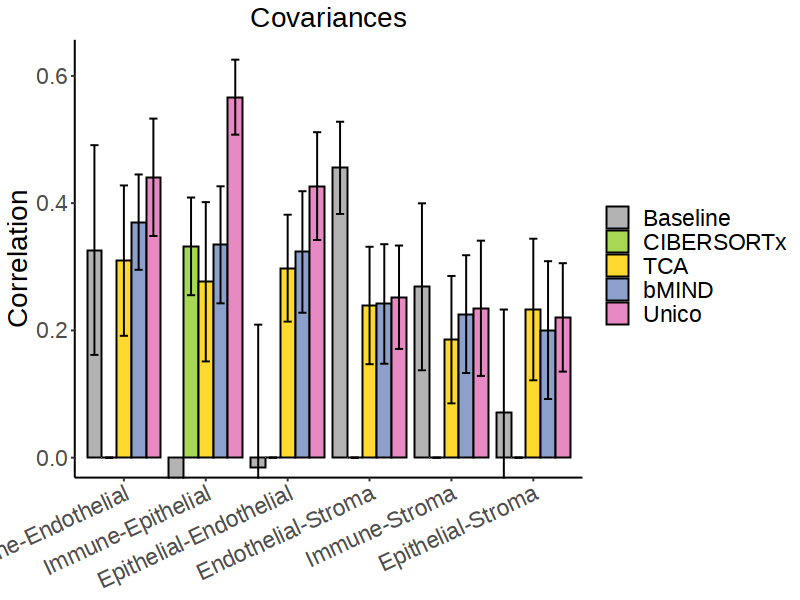

In [19]:
covar.bar.g = ggplot(covar.barplot.df, aes(x=as.factor(source), y=mean, fill=method)) +
              geom_bar(position=position_dodge(.9), stat="identity", colour='black') + 
              
              geom_errorbar(aes(ymin = lb_sd, ymax= ub_sd), width=.5, position=position_dodge(.9)) +                                                
              coord_cartesian(ylim = c(0, max(covar.barplot.df$ub_sd))) + 
              scale_fill_manual(values = method.colors) + 
              ggtitle("Covariances") + 
              xlab(paste0("Cell Type Pairs")) + 
              ylab(paste0("Correlation")) + 
              theme_classic() + 
              theme(plot.title = element_text(hjust = 0.5, size = title.size),
                    text=element_text(size=lab.size), #text size
                    axis.text.x  = element_text(angle = 25, vjust = 1, hjust = 1), #rotate
                    axis.title.x = element_blank(), # no x tilte
                    legend.title = element_blank())
 
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 100)
covar.bar.g

# Bar plot

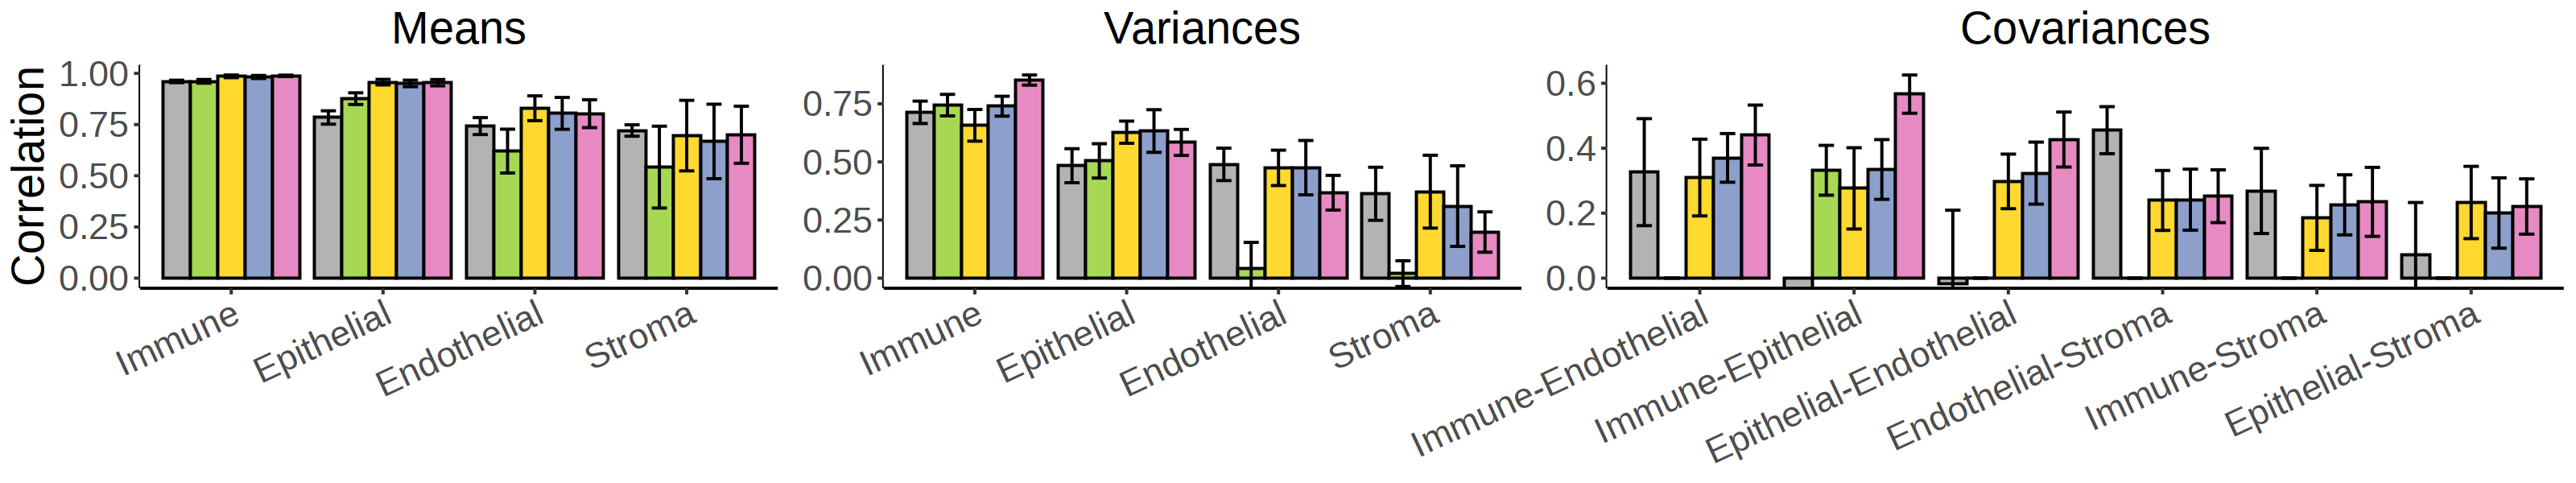

In [20]:
plts = list(3)
plts[[1]] = mean.bar.g  + theme(legend.position="none") 
plts[[2]] = var.bar.g   + theme(legend.position="none") + theme(axis.title.y = element_blank()) 
plts[[3]] = covar.bar.g + theme(legend.position="none") + theme(axis.title.y = element_blank())

#too many celltypes. shrink the size
if(source.col == "decon.L2"){
    plts[[1]] = plts[[1]] +  theme(text=element_text(size=lab.size - 2.5))
    plts[[2]] = plts[[2]] +  theme(text=element_text(size=lab.size - 2.5))
    plts[[3]] = plts[[3]] +  theme(text=element_text(size=lab.size - 2.5))
}

covar.width   = round(2 * length(covar.ids)/length(source.ids))
#figure.width  = (4 + covar.width) * 3
#figure.height = 7 

options(repr.plot.width = 16, repr.plot.height = 3, repr.plot.res = 200)
params.bar.g = egg::ggarrange(plots=list(plts[[1]], plts[[2]], plts[[3]]),  
                    #labels = c("a", "", ""), 
                    align = "h",
                    widths = c(2,2,covar.width),  
                    #label.args = list(gp = grid::gpar(font = 20, cex =3)), 
                    debug=F)

# box plot

### step1: prepare the boxplot needed correlation 

In [21]:
for (t in ts){
    sim.data.list[[t]]$eval.feature.source = calc_variable_feature_source(sim.data.list[[t]]$Z.scale, 
                                                                          variable_thr = 0.1, max_sds = max_stds)
    
    #sim.data.list[[t]]$eval.entropies = sim.data.list[[t]]$params$entropies <= sim.data.list[[t]]$data.gen.params$entropy.thr
    # arbitray cut to low and high entropy group
    sim.data.list[[t]]$eval.entropies = sim.data.list[[t]]$params$entropies <= median(sim.data.list[[t]]$params$entropies)
    sim.data.list[[t]]$eval.entropies = as.matrix(vapply(1:m, function(j) if (sim.data.list[[t]]$eval.entropies[j]) "Low Entropy" else "High Entropy", character(1)))
}

Z.corrs.list = list(
    #m*t by k 
    Baseline       = concat_key(base.mdl.list,       key = "Z.corrs"),                
    CIBERSORTx     = concat_key(cibersortx.mdl.list, key = "Z.corrs"),                    
    TCA            = concat_key(tca.mdl.list,        key = "Z.corrs"),                     
    TCAx           = concat_key(tcax.mdl.list,       key = "Z.corrs"),
    bMIND          = concat_key(bMIND.mdl.list,      key = "Z.corrs"),

    mask           = concat_key(sim.data.list,       key = "eval.feature.source"),
    #m*t by 1
    eval.entropies = concat_key(sim.data.list,       key = "eval.entropies")
)

In [22]:
median(sim.data.list[[t]]$params$entropies)

[1] 1.25655

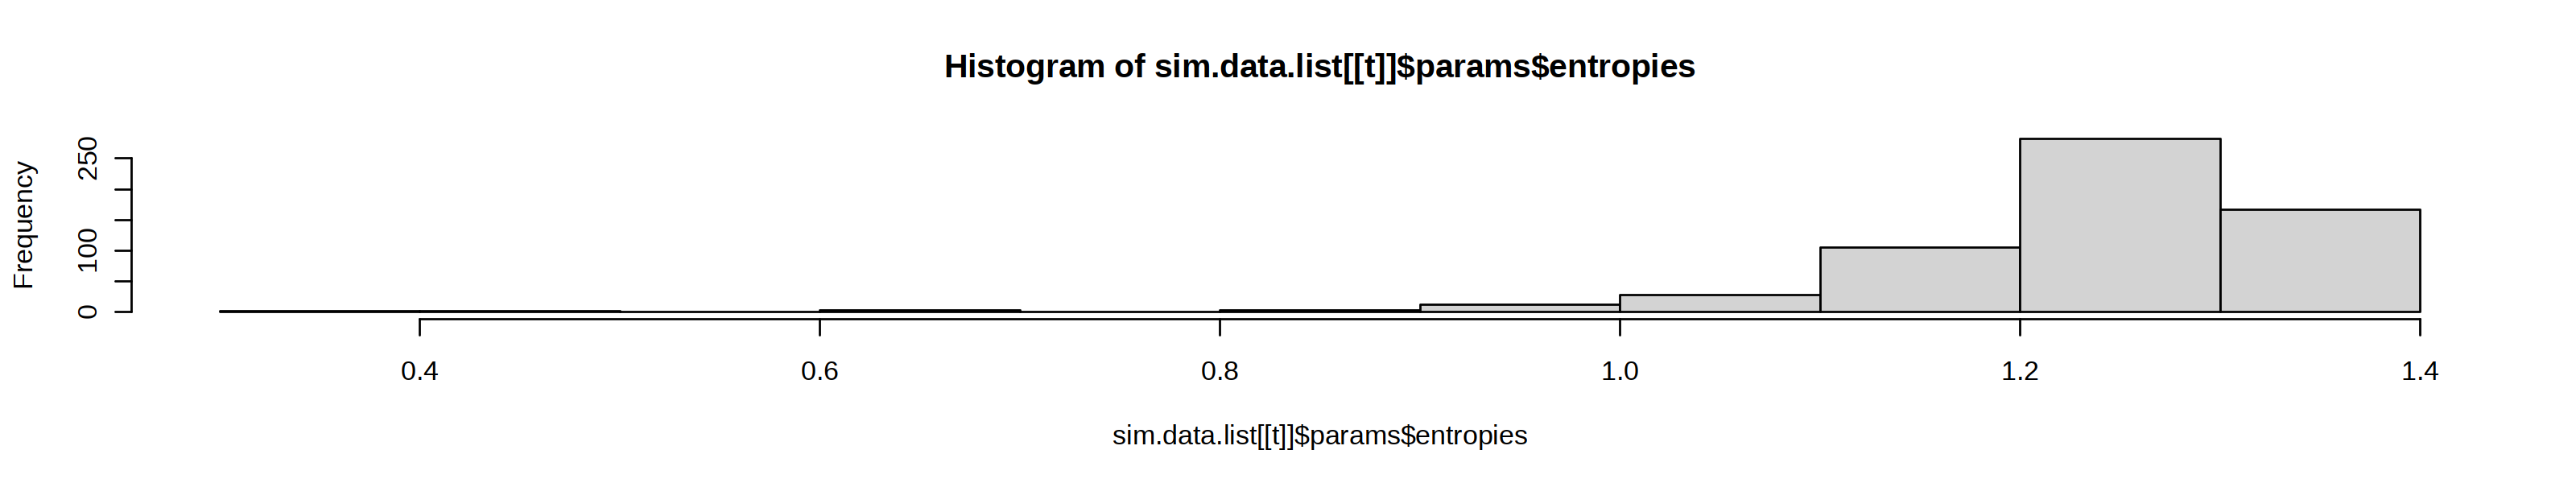

In [23]:
hist(sim.data.list[[t]]$params$entropies)

In [24]:
table(sim.data.list[[t]]$eval.entropies)


High Entropy  Low Entropy 
         300          300 

### step2: prepare p-vals related

In [25]:
boxplot.meta = list()
for (source.id in source.ids){
    
    median.mat       = matrix(0, 2, length(methods))
    rownames(median.mat) = c("High Entropy", "Low Entropy")
    colnames(median.mat) = methods
    
    whitney.pval.mat = copy(median.mat)
    binom.pval.mat   = copy(median.mat)
    n.success.mat    = copy(median.mat)
    p.success.mat    = copy(median.mat)
    
    for (entropy in c("High Entropy" ,"Low Entropy")){
        
        # selected gene in the ideal entropy group and deemed to be evaluated 
        keep.mask = (Z.corrs.list$eval.entropies == entropy) & Z.corrs.list$mask[,source.id]
        
        for (method in methods){
            method.corrs = Z.corrs.list[[method]][keep.mask, source.id]
            tcax.corrs   = Z.corrs.list[["TCAx"]][keep.mask, source.id]
            
            #paired one side non-parametric whitney test
            median.mat[entropy, method] = median(method.corrs)
            res = wilcox.test(x = tcax.corrs, 
                              y = method.corrs, 
                              alternative = "g", paired = T) # x > y one side test 
            whitney.pval.mat[entropy,method] = res$p.value
            
            #binomial test
            n_s = sum(tcax.corrs > method.corrs)                          
            n   = sum(keep.mask)
            res = binom.test(x = n_s, n = n, p = 0.5, alternative = c("greater"))
            binom.pval.mat[entropy,method] = res$p.value
            n.success.mat[entropy,method]  = n_s
            p.success.mat[entropy,method]  = n_s/n
            
        }
        boxplot.meta[[source.id]] = list(median.mat       = median.mat,
                                         whitney.pval.mat = whitney.pval.mat,
                                         binom.pval.mat   = binom.pval.mat,
                                         n.success.mat    = n.success.mat,
                                         p.success.mat    = p.success.mat)
    }
}

Warning message in wilcox.test.default(x = tcax.corrs, y = method.corrs, alternative = "g", :
“cannot compute exact p-value with zeroes”
Warning message in wilcox.test.default(x = tcax.corrs, y = method.corrs, alternative = "g", :
“cannot compute exact p-value with zeroes”
Warning message in wilcox.test.default(x = tcax.corrs, y = method.corrs, alternative = "g", :
“cannot compute exact p-value with zeroes”
Warning message in wilcox.test.default(x = tcax.corrs, y = method.corrs, alternative = "g", :
“cannot compute exact p-value with zeroes”
Warning message in wilcox.test.default(x = tcax.corrs, y = method.corrs, alternative = "g", :
“cannot compute exact p-value with zeroes”
Warning message in wilcox.test.default(x = tcax.corrs, y = method.corrs, alternative = "g", :
“cannot compute exact p-value with zeroes”
Warning message in wilcox.test.default(x = tcax.corrs, y = method.corrs, alternative = "g", :
“cannot compute exact p-value with zeroes”
Warning message in wilcox.test.default(x 

In [26]:
head(Z.corrs.list[["TCAx"]])

Immune    Epithelial Endothelial Stroma    
ENSG00000184990 0.8419408 0.7800638  0.6321150    0.4899267
ENSG00000148053        NA        NA  0.5565577    0.1079976
ENSG00000204713 0.8757054 0.5708502  0.5538219   -0.1700513
ENSG00000157077        NA 0.4763767  0.5221520   -0.1382584
ENSG00000007341 0.8714811 0.5273272  0.5550348   -0.4277789
ENSG00000178585 0.6914132 0.7656389  0.2645681    0.3867825

In [27]:
boxplot.meta

$Immune
$Immune$median.mat
              Baseline CIBERSORTx       TCA     bMIND      TCAx
High Entropy 0.6359399  0.7996686 0.8368804 0.8478176 0.8603056
Low Entropy  0.6878147  0.8532040 0.8660327 0.8780829 0.8942069

$Immune$whitney.pval.mat
             Baseline CIBERSORTx           TCA         bMIND TCAx
High Entropy        0          0  1.599306e-59  1.403803e-49    1
Low Entropy         0          0 4.199427e-240 1.877063e-187    1

$Immune$binom.pval.mat
             Baseline CIBERSORTx           TCA         bMIND TCAx
High Entropy        0          0  5.805976e-57  8.922210e-48    1
Low Entropy         0          0 4.542001e-199 2.909221e-171    1

$Immune$n.success.mat
             Baseline CIBERSORTx  TCA bMIND TCAx
High Entropy     4074       3675 2677  2632    0
Low Entropy      4962       4123 3649  3573    0

$Immune$p.success.mat
              Baseline CIBERSORTx       TCA     bMIND TCAx
High Entropy 0.9439296  0.8514829 0.6202502 0.6098239    0
Low Entropy  0.9603251  0.7979485 0.7062125 0.6915038    0


$Epithelial
$Epithelial$median.mat
              Baseline CIBERSORTx       TCA     bMIND      TCAx
High Entropy 0.1919785  0.4560207 0.5008807 0.4724407 0.5783436
Low Entropy  0.2233213  0.5504918 0.5464060 0.5250438 0.6867903

$Epithelial$whitney.pval.mat
             Baseline CIBERSORTx          TCA bMIND TCAx
High Entropy        0          0 4.74577e-246     0    1
Low Entropy         0          0  0.00000e+00     0    1

$Epithelial$binom.pval.mat
             Baseline CIBERSORTx          TCA bMIND TCAx
High Entropy        0          0 1.23522e-215     0    1
Low Entropy         0          0  0.00000e+00     0    1

$Epithelial$n.success.mat
             Baseline CIBERSORTx  TCA bMIND TCAx
High Entropy     4765       3992 3536  3894    0
Low Entropy      5211       4060 4517  4716    0

$Epithelial$p.success.mat
              Baseline CIBERSORTx       TCA     bMIND TCAx
High Entropy 0.9698758  0.8125382 0.7197232 0.7925911    0
Low Entropy  0.9848800  0.7673408 0.8537139 0.8913249    0


$Endothelial
$Endothelial$median.mat
              Baseline CIBERSORTx       TCA     bMIND      TCAx
High Entropy 0.1014784          0 0.3266148 0.2755067 0.4069339
Low Entropy  0.1366889          0 0.4002576 0.3403955 0.5487258

$Endothelial$whitney.pval.mat
             Baseline CIBERSORTx           TCA bMIND TCAx
High Entropy        0          0 9.605292e-190     0    1
Low Entropy         0          0  0.000000e+00     0    1

$Endothelial$binom.pval.mat
             Baseline CIBERSORTx           TCA bMIND TCAx
High Entropy        0          0 8.432132e-202     0    1
Low Entropy         0          0  0.000000e+00     0    1

$Endothelial$n.success.mat
             Baseline CIBERSORTx  TCA bMIND TCAx
High Entropy     4441       4359 3501  3933    0
Low Entropy      5060       4909 4583  4822    0

$Endothelial$p.success.mat
              Baseline CIBERSORTx       TCA     bMIND TCAx
High Entropy 0.9041124  0.8874186 0.7127443 0.8006922    0
Low Entropy  0.9379055  0.9099166 0.8494903 0.8937905    0


$Stroma
$Stroma$median.mat
               Baseline CIBERSORTx       TCA     bMIND      TCAx
High Entropy 0.06814362          0 0.2056723 0.1429082 0.2177644
Low Entropy  0.12469511          0 0.2915976 0.2128572 0.3641226

$Stroma$whitney.pval.mat
                  Baseline    CIBERSORTx          TCA         bMIND TCAx
High Entropy 4.349385e-252 8.284582e-299 5.483143e-03  2.478546e-85    1
Low Entropy  7.274285e-275  0.000000e+00 9.912535e-59 6.176294e-161    1

$Stroma$binom.pval.mat
                  Baseline    CIBERSORTx           TCA         bMIND TCAx
High Entropy 1.159202e-272 1.625682e-258  1.838014e-15  6.113325e-95    1
Low Entropy   0.000000e+00  0.000000e+00 4.239335e-150 1.047777e-284    1

$Stroma$n.success.mat
             Baseline CIBERSORTx  TCA bMIND TCAx
High Entropy     3725       3694 2782  3229    0
Low Entropy      4305       4294 3677  4028    0

$Stroma$p.success.mat
              Baseline CIBERSOR

In [28]:
boxplot.meta[[1]]$whitney.pval.mat

Baseline CIBERSORTx TCA           bMIND         TCAx
High Entropy 0        0           1.599306e-59  1.403803e-49 1   
Low Entropy  0        0          4.199427e-240 1.877063e-187 1

### step3: set some fontsize 

In [29]:
if(data.name == "PBMC"){
    if (source.col == "decon.L1"){
        sub.titles = c("CD4 T Cells", "NK Cells", "CD8 T Cells", "Monocytes", "B Cells")
    }else{
        sub.titles = c("CD4 T Cells", "NK Cells", "CD8 T Cells", "Monocytes (CD14)", "B Cells", "Monocytes (CD16)", "Plasma" )
    }
}else{
    if (source.col == "decon.L1"){
        sub.titles = source.ids
    }else{
        sub.titles = source.ids
    }
}

print(source.ids)
print(sub.titles)

[1] "Immune"      "Epithelial"  "Endothelial" "Stroma"     
[1] "Immune"      "Epithelial"  "Endothelial" "Stroma"     


In [30]:
h.loc = linspace(0.64, 1.36, 5)
v.loc = linspace(1.0, 1.3, 4)
v.size = 0.02
p.size = 4

under.flow = "< 1e-300"
#under.flow = "***"

In [31]:
W = concat_key(sim.data.list, "W")
plts <- vector(mode = "list", length = k)
m.m = nrow(Z.corrs.list$eval.entropies)
for (h in 1:k){
    Z.boxplot.df <- data.frame(cor     = as.vector(vapply(1:length(methods), function(a) Z.corrs.list[[methods[a]]][,h],   numeric(m.m))),
                               mask    = as.vector(vapply(1:length(methods), function(a) Z.corrs.list[["mask"]][,h],       logical(m.m))),
                               entropy = as.vector(vapply(1:length(methods), function(a) Z.corrs.list[["eval.entropies"]], character(m.m))),
                               method  = as.vector(vapply(1:length(methods), function(a) rep(methods[a], m.m),             character(m.m))))
    # set some to factors so that the figures respect the order                                                     
    Z.boxplot.df$method  = factor(Z.boxplot.df$method,  levels = methods) 
    Z.boxplot.df$entropy = factor(Z.boxplot.df$entropy, levels = c("High Entropy", "Low Entropy"))
    levels(Z.boxplot.df$method)[match("TCAx",levels(Z.boxplot.df$method))] <- "Unico"
                                                          
    #keep only those gene-celltype that has evaluation turned on 
    Z.boxplot.df = Z.boxplot.df[Z.boxplot.df$mask, ]
    print(dim(Z.boxplot.df))                                                 
                                                     
    plts[[h]] <- ggplot(Z.boxplot.df, aes(x = entropy, y=cor)) +
                 geom_boxplot(aes(fill = method), position = position_dodge(0.9))+    
                 scale_fill_manual (values = method.colors) +
                 scale_color_manual(values = method.colors) +
                                                                
                 coord_cartesian(xlim = NULL, ylim = c(0,1 + (length(methods)-2)/10)) +  
                 xlab(paste0(" "))+                                    
                 ylab(paste0("Correlation"))+
                 scale_y_continuous(breaks=c(0, 0.2, 0.4, 0.6, 0.8, 1.0)) + 
                                                          
                 ggtitle(paste0(sub.titles[h], " (", round(mean(W[,h]) * 100), "%)")) + 
                 theme_classic() + 
                 theme(plot.title = element_text(hjust = 0.5, size = title.size),
                       text=element_text(size=lab.size),
                       legend.title = element_blank())
                                                     
    #adding p-vales
    whitney.pval.mat = formatC(boxplot.meta[[h]]$whitney.pval.mat, format = "e", digits = 1) 
    whitney.pval.mat[which(whitney.pval.mat == "0.0e+00")] = under.flow
          
    df1 <- data.frame(a = c(h.loc[1],h.loc[1], h.loc[5], h.loc[5]), b = c(v.loc[1]-v.size, v.loc[1], v.loc[1], v.loc[1]-v.size))
    df2 <- data.frame(a = c(h.loc[2],h.loc[2], h.loc[5], h.loc[5]), b = c(v.loc[2]-v.size, v.loc[2], v.loc[2], v.loc[2]-v.size))
    df3 <- data.frame(a = c(h.loc[3],h.loc[3], h.loc[5], h.loc[5]), b = c(v.loc[3]-v.size, v.loc[3], v.loc[3], v.loc[3]-v.size))
    df4 <- data.frame(a = c(h.loc[4],h.loc[4], h.loc[5], h.loc[5]), b = c(v.loc[4]-v.size, v.loc[4], v.loc[4], v.loc[4]-v.size))


    df5 <- data.frame(a = 1 + c(h.loc[1],h.loc[1], h.loc[5], h.loc[5]), b = c(v.loc[1]-v.size, v.loc[1], v.loc[1], v.loc[1]-v.size))
    df6 <- data.frame(a = 1 + c(h.loc[2],h.loc[2], h.loc[5], h.loc[5]), b = c(v.loc[2]-v.size, v.loc[2], v.loc[2], v.loc[2]-v.size))
    df7 <- data.frame(a = 1 + c(h.loc[3],h.loc[3], h.loc[5], h.loc[5]), b = c(v.loc[3]-v.size, v.loc[3], v.loc[3], v.loc[3]-v.size))
    df8 <- data.frame(a = 1 + c(h.loc[4],h.loc[4], h.loc[5], h.loc[5]), b = c(v.loc[4]-v.size, v.loc[4], v.loc[4], v.loc[4]-v.size))
                                                          
    plts[[h]] <- plts[[h]] + geom_line(data = df1, aes(x = a, y = b)) + annotate("text", x = (h.loc[1]+ h.loc[5])/2,   y = v.loc[1] + 2*v.size, label = whitney.pval.mat[1,1], size = p.size) +
                             geom_line(data = df2, aes(x = a, y = b)) + annotate("text", x = (h.loc[2]+ h.loc[5])/2,   y = v.loc[2] + 2*v.size, label = whitney.pval.mat[1,2], size = p.size) +
                             geom_line(data = df3, aes(x = a, y = b)) + annotate("text", x = (h.loc[3]+ h.loc[5])/2,   y = v.loc[3] + 2*v.size, label = whitney.pval.mat[1,3], size = p.size) +
                             geom_line(data = df4, aes(x = a, y = b)) + annotate("text", x = (h.loc[4]+ h.loc[5])/2,   y = v.loc[4] + 2*v.size, label = whitney.pval.mat[1,4], size = p.size) +
                                                          
                             geom_line(data = df5, aes(x = a, y = b)) + annotate("text", x = 1+(h.loc[1]+ h.loc[5])/2, y = v.loc[1] + 2*v.size, label = whitney.pval.mat[2,1], size = p.size) +
                             geom_line(data = df6, aes(x = a, y = b)) + annotate("text", x = 1+(h.loc[2]+ h.loc[5])/2, y = v.loc[2] + 2*v.size, label = whitney.pval.mat[2,2], size = p.size) +
                             geom_line(data = df7, aes(x = a, y = b)) + annotate("text", x = 1+(h.loc[3]+ h.loc[5])/2, y = v.loc[3] + 2*v.size, label = whitney.pval.mat[2,3], size = p.size) +
                             geom_line(data = df8, aes(x = a, y = b)) + annotate("text", x = 1+(h.loc[4]+ h.loc[5])/2, y = v.loc[4] + 2*v.size, label = whitney.pval.mat[2,4], size = p.size) 
          
                                                          
                                                          
                                                          
#     # legend
#     if (h != ceil(k/2)){
#         plts[[h]] = plts[[h]]  + theme(legend.position="none") 
#     }else{
#         plts[[h]] = plts[[h]]  + theme(legend.text = element_text(size=legend.size)) 
#     }
#    plts[[h]] = plts[[h]] +  labs(tag = " ")  
    plts[[h]] = plts[[h]] + theme(legend.position="none") 
}

[1] 47415     4
[1] 51020     4
[1] 51535     4
[1] 52280     4


In [32]:
Z.boxplot.df

cor          mask entropy      method  
1      0.009525825 TRUE Low Entropy  Baseline
2      0.015989005 TRUE High Entropy Baseline
3      0.016353174 TRUE Low Entropy  Baseline
4     -0.023241552 TRUE High Entropy Baseline
5      0.169801085 TRUE Low Entropy  Baseline
6     -0.044394959 TRUE High Entropy Baseline
7     -0.004801494 TRUE High Entropy Baseline
8      0.115814916 TRUE Low Entropy  Baseline
9      0.341996431 TRUE Low Entropy  Baseline
10     0.135019135 TRUE High Entropy Baseline
12     0.085733063 TRUE Low Entropy  Baseline
14     0.121386975 TRUE High Entropy Baseline
15     0.115104943 TRUE High Entropy Baseline
17     0.048510933 TRUE Low Entropy  Baseline
18     0.060234932 TRUE Low Entropy  Baseline
19     0.113955767 TRUE Low Entropy  Baseline
20     0.040561449 TRUE Low Entropy  Baseline
21     0.237301845 TRUE Low Entropy  Baseline
23     0.059722794 TRUE High Entropy Baseline
24     0.317062585 TRUE High Entropy Baseline
27     0.109343780 TRUE High Entropy Baseline
28    -0.014296630 TRUE High Entropy Baseline
30     0.166353306 TRUE High Entropy Baseline
31    -0.102079591 TRUE High Entropy Baseline
32     0.172865603 TRUE Low Entropy  Baseline
34    -0.062580794 TRUE High Entropy Baseline
35     0.003013925 TRUE High Entropy Baseline
37     0.185915361 TRUE High Entropy Baseline
38     0.179027708 TRUE Low Entropy  Baseline
39     0.026667463 TRUE High Entropy Baseline
⋮     ⋮            ⋮    ⋮            ⋮       
59965 -0.01903264  TRUE High Entropy Unico   
59966 -0.47154418  TRUE Low Entropy  Unico   
59967  0.27046002  TRUE High Entropy Unico   
59968  0.23297132  TRUE Low Entropy  Unico   
59970  0.44224073  TRUE High Entropy Unico   
59973 -0.57706797  TRUE Low Entropy  Unico   
59975  0.55724501  TRUE High Entropy Unico   
59976  0.49167563  TRUE High Entropy Unico   
59977  0.38680527  TRUE Low Entropy  Unico   
59978  0.02467396  TRUE High Entropy Unico   
59979 -0.23378178  TRUE High Entropy Unico   
59980  0.45859791  TRUE High Entropy Unico   
59981 -0.04524926  TRUE Low Entropy  Unico   
59982  0.51634016  TRUE High Entropy Unico   
59983  0.56810164  TRUE Low Entropy  Unico   
59984  0.65618365  TRUE Low Entropy  Unico   
59985  0.55096298  TRUE Low Entropy  Unico   
59986 -0.39060135  TRUE Low Entropy  Unico   
59987  0.65965782  TRUE Low Entropy  Unico   
59988  0.39456809  TRUE Low Entropy  Unico   
59989  0.44590466  TRUE High Entropy Unico   
59990 -0.51383723  TRUE Low Entropy  Unico   
59991  0.25380339  TRUE High Entropy Unico   
59993  0.31051947  TRUE Low Entropy  Unico   
59994 -0.11139062  TRUE High Entropy Unico   
59995  0.48438997  TRUE High Entropy Unico   
59997  0.48733899  TRUE Low Entropy  Unico   
59998  0.52265897  TRUE Low Entropy  Unico   
59999  0.38941771  TRUE Low Entropy  Unico   
60000  0.21083473  TRUE High Entropy Unico

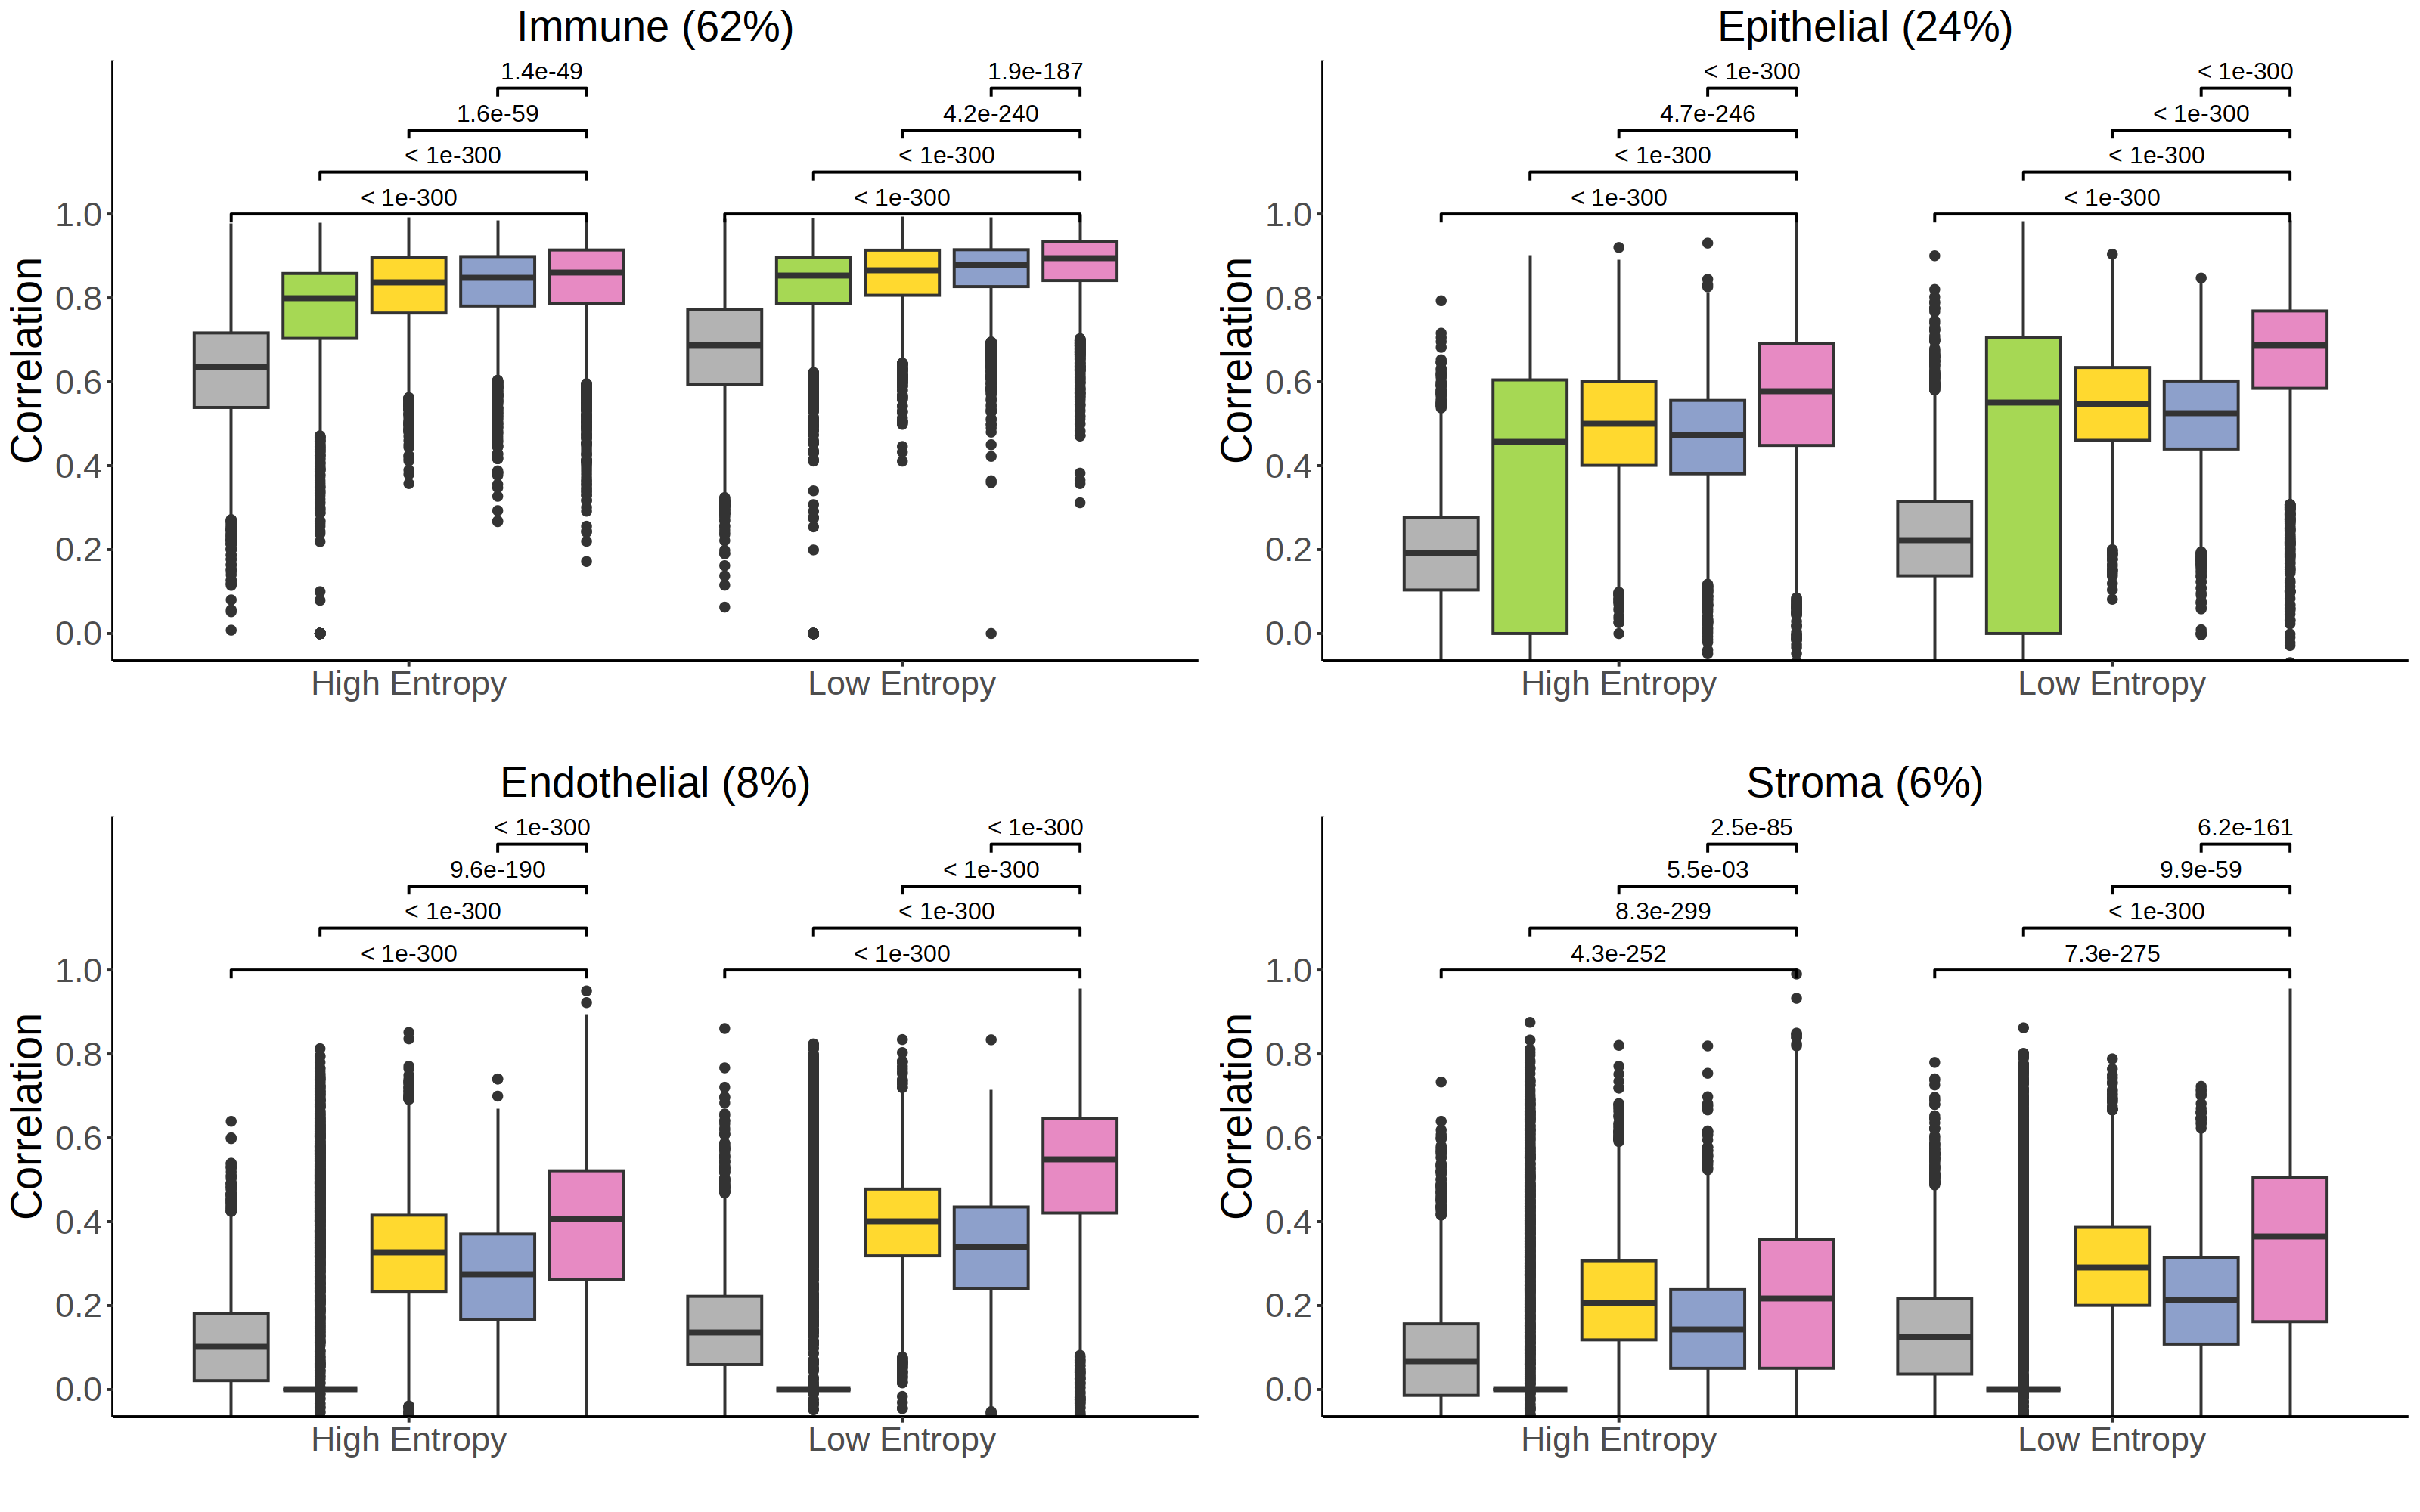

In [33]:
# figure.width  = (ceil(k/2) + 1) * 6
# figure.height = 2 * 6 + 2

options(repr.plot.width = 16, repr.plot.height = 10, repr.plot.res = 200)
cor.box.g = egg::ggarrange(plots = plts,
                           #labels = c("b", rep("", (length(source.ids) ))),
                           align = "h",
                           widths = rep(2, ceil(k/2)),  
                           #label.args = list(gp = grid::gpar(font = 20, cex =3)), 
                           debug=F)


# additional signal

In [34]:
# might see underflow if Z.hat has pval 1 due to not fitted, and bulk has p val whose -log10 value smaller than 300 
min.log10p.diff = -300


In [35]:
#list of matricies
#each entry is a method
joint.bulk.Z.hat.log10p.diff.list = list(
    #m*t by k 
    Baseline       = concat_key(base.mdl.list,       key = "joint.bulk.Z.hat.log10p.diff"),               
    CIBERSORTx     = concat_key(cibersortx.mdl.list, key = "joint.bulk.Z.hat.log10p.diff"),                    
    TCA            = concat_key(tca.mdl.list,        key = "joint.bulk.Z.hat.log10p.diff"),                     
    TCAx           = concat_key(tcax.mdl.list,       key = "joint.bulk.Z.hat.log10p.diff"),
    bMIND          = concat_key(bMIND.mdl.list,      key = "joint.bulk.Z.hat.log10p.diff"),
    mask           = concat_key(sim.data.list,       key = "eval.feature.source"),
    #m*t by 1
    eval.entropies = concat_key(sim.data.list,       key = "eval.entropies")
)

In [36]:
names(joint.bulk.Z.hat.log10p.diff.list)

[1] "Baseline"       "CIBERSORTx"     "TCA"            "TCAx"          
[5] "bMIND"          "mask"           "eval.entropies"

In [37]:
#those that have too small variance are ignored
joint.bulk.Z.hat.log10p.diff.list$TCAx

Immune      Epithelial  Endothelial Stroma     
ENSG00000184990 -3.15211490   0.2895290 -1.04806392 -0.91528587
ENSG00000148053          NA          NA  1.34789622 -1.33678469
ENSG00000204713  5.77569344  -1.5717479  1.21189697 -1.87390839
ENSG00000157077          NA  -1.1068502  3.61228934 -1.99631536
ENSG00000007341  0.96853014   0.2998500  0.16294935 -0.34635962
ENSG00000178585  0.08306412   0.8228731 -0.75273816 -0.58156286
ENSG00000147383          NA   1.5898076  0.61539753 -0.08197391
ENSG00000136930 -1.05331124  -0.5543350 -2.23788867 -3.85122906
ENSG00000139631 -2.10879842   1.7882998 -1.45603823 -0.94705305
ENSG00000153446          NA  11.5640097          NA  1.31943634
ENSG00000206199          NA  -7.6268803          NA          NA
ENSG00000127666  3.35283668  -0.6769474 -0.48334602 -0.42389744
ENSG00000178695  0.24389701          NA  0.20710650          NA
ENSG00000125741 -1.89644325   0.8627609 -1.31498480  0.06034683
ENSG00000167642          NA   3.0054293          NA -1.22618033
ENSG00000115112 -4.65559384   0.2344995          NA          NA
ENSG00000141994 -3.13727649  -0.5913293 -0.61071820 -0.78209152
ENSG00000132603  2.16614955   0.2652710 -1.15636286 -3.40109170
ENSG00000149792 -3.82268336  -4.9018315 -1.81310847 -0.72260042
ENSG00000130159  0.36826633  -0.3142403  0.10452786 -3.58057549
ENSG00000109381  0.48766770  -6.3997566 -0.69959870 -1.67502391
ENSG00000115339          NA   2.6021878          NA          NA
ENSG00000131378 -2.39516323  -0.4537132 -0.55296895 -3.63857128
ENSG00000134321 -4.41384655   2.2898975  2.69495427 -2.81794972
ENSG00000136352          NA  10.9832239          NA          NA
ENSG00000164023 -2.94851789   1.5677919          NA          NA
ENSG00000129353 -7.28810947  -2.6254587 -2.74175759 -0.15289033
ENSG00000163527  2.60641326   0.4408815 -0.01620207 -0.79066575
ENSG00000160472          NA -27.5117242          NA          NA
ENSG00000178498 -4.20400073   0.5047511 -0.87807025 -1.60145172
⋮               ⋮           ⋮           ⋮           ⋮          
ENSG00000135077  8.05926192          NA          NA          NA
ENSG00000104450          NA -2.29355637          NA          NA
ENSG00000219545  0.48646451 -0.66274853 -0.41094667 -2.14956530
ENSG00000101443          NA  5.54199866          NA          NA
ENSG00000162542          NA          NA          NA  0.02190048
ENSG00000188938  2.27117292  2.70383684  0.17867152 -0.45365601
ENSG00000174839 -0.28510358  0.08595824 -0.09795479 -0.58077690
ENSG00000090615 -0.03413588  0.12859997  0.46669039  0.10150278
ENSG00000066379 -4.88899796  0.59441425 -3.58985819 -1.37974336
ENSG00000182704          NA          NA -1.25083649 -1.84305714
ENSG00000075711 -7.69815809 -0.09342392  1.43340831  0.74160214
ENSG00000165806  2.69747859  0.02837084  0.82745331 -0.21252882
ENSG00000107874  6.38130558 -0.51509751  1.63077700 -0.85027059
ENSG00000129518 -0.56597421 -0.23788591  0.98862073  0.44278374
ENSG00000168958 -3.77667047 -0.61172744  0.04656251 -1.66967902
ENSG00000171298 -6.01395203          NA  0.63467558 -0.56672466
ENSG00000123094          NA  1.26060991 -1.36771600  0.57379384
ENSG00000155827 -0.07826248  1.25520730 -0.13002854 -5.34112417
ENSG00000126214  0.18950963  0.19248455  0.75823897  0.10819939
ENSG00000086102  1.04024534 -2.40294778  0.39055565 -1.37170063
ENSG00000196639          NA          NA  1.36782085 -0.65876320
ENSG00000005108          NA -0.79493991 -0.24360579          NA
ENSG00000120029 -3.57989416  0.68664646 -0.47914170  0.19778932
ENSG00000102218 -2.17257723  0.23487290  0.05633264 -0.08607092
ENSG00000165512 -1.25418007 -1.13746968  0.10614222  0.75988267
ENSG00000130513          NA  1.35590405  0.29686123          NA
ENSG00000105402 -0.45314526 -0.63301815 -3.63510199 -3.91571651
ENSG00000134970  0.50922436 -2.03103518 -0.22630708 -1.32074061
ENSG00000260708  3.24257772 -1.65225397 -2.12692968 -0.40915083
ENSG00000156535 -2.52711156          NA  0.34322445 -1.10403291

In [38]:
plot.list = joint.bulk.Z.hat.log10p.diff.list

In [39]:
plot.list["TCA"]

$TCA
                       Immune    Epithelial   Endothelial        Stroma
ENSG00000184990   3.112044312 -2.293571e+00 -4.608770e+00 -1.565723e+00
ENSG00000148053            NA            NA -2.242545e+00 -1.124103e+00
ENSG00000204713   2.637968664 -5.133324e+00 -2.503660e-01 -3.336364e+00
ENSG00000157077            NA  1.505132e-02  1.267855e+00 -1.676777e+00
ENSG00000007341  -0.513292791  6.789670e-01 -2.552766e+00 -1.983214e+00
ENSG00000178585  -4.355466901 -1.341725e+00 -1.517105e+00 -4.462352e-01
ENSG00000147383            NA  4.682634e-01 -1.068469e+00 -1.263818e-01
ENSG00000136930   0.383073704 -7.192283e+00 -2.643945e+00 -3.807253e+00
ENSG00000139631   3.479770174  2.980415e+00 -3.859720e+00 -7.123673e+00
ENSG00000153446            NA -1.286761e+00            NA -1.849449e+00
ENSG00000206199            NA -2.359335e+01            NA            NA
ENSG00000127666   6.145967534 -2.693924e+00 -1.294941e+00 -9.632968e-01
ENSG00000178695  -5.438859630            NA  3.605984e-02            NA
ENSG00000125741   0.515725383  2.381959e-01 -2.309487e+00  4.654243e-01
ENSG00000167642            NA  1.637355e+00            NA -1.611856e+00
ENSG00000115112   2.438904155 -1.335828e+00            NA            NA
ENSG00000141994  -0.089719313 -7.050813e+00 -3.240253e+00 -3.106666e+00
ENSG00000132603  -3.806412297 -8.188710e+00 -9.615800e+00 -8.237395e+00
ENSG00000149792   0.882808815 -2.080917e-01 -3.361884e+00 -1.168833e+00
ENSG00000130159  -3.917584847 -2.025102e+00  5.382953e-02 -1.716373e+00
ENSG00000109381   1.016440088 -4.989094e+00 -2.087688e+00 -3.289424e+00
ENSG00000115339            NA  5.616220e+00            NA            NA
ENSG00000131378   1.387032749  9.878593e-01 -1.730803e+00 -3.737704e+00
ENSG00000134321  -1.973838464 -1.043060e+01  2.726175e-01 -1.214969e+00
ENSG00000136352            NA  1.455807e+00            NA            NA
ENSG00000164023 -15.344111789  1.009326e+00            NA            NA
ENSG00000129353  -4.508951646 -1.230366e+01 -6.153834e+00 -3.527594e+00
ENSG00000163527   4.002470813 -2.484530e-01 -7.028195e-02 -2.838191e+00
ENSG00000160472            NA -3.403189e+01            NA            NA
ENSG00000178498   2.791000208  3.120230e-02 -4.180227e+00 -2.968527e+00
ENSG00000131389  -0.518434861 -1.411170e+00 -1.634049e+00  2.669160e-01
ENSG00000166377  -1.749439464 -6.020055e+00  3.978809e-01 -1.794185e-01
ENSG00000031081  -1.076706581 -2.222281e+00 -6.403623e-02            NA
ENSG00000110841            NA            NA  3.248579e-01 -2.712348e+00
ENSG00000103496  -2.572175438  6.038862e-01 -2.087755e-01 -1.385946e+00
ENSG00000154065            NA -3.107166e+00            NA            NA
ENSG00000246695  -4.421970023  3.229887e+00 -5.601961e-01 -1.060478e+00
ENSG00000117410  -1.805780552  9.538496e-01  3.139639e-01 -1.222179e+00
ENSG00000105185  -0.920243249 -2.264744e+00 -1.803245e+00 -9.423593e-01
ENSG00000163510  -0.355919751 -1.270737e+00 -7.092072e-01 -1.994299e+00
ENSG00000007923  -7.087478313 -1.493445e+01 -6.839322e-01 -1.115594e+00
ENSG00000103351            NA -5.458533e+00 -1.007038e+00 -1.625118e+00
ENSG00000031003  -1.789256555 -6.993678e-01 -2.568912e+00 -3.425620e+00
ENSG00000213983   0.677325034 -1.930288e+01 -2.904110e+00  1.443162e-01
ENSG00000152952            NA -4.023435e-01  2.861745e-01 -1.872371e-01
ENSG00000143952   0.324505618 -3.080851e+00  4.947245e-01 -1.186934e+00
ENSG00000132952   2.676124679            NA  6.487167e-01 -2.856204e-01
ENSG00000101333            NA -1.471061e+00 -8.145714e-02 -1.800603e+00
ENSG00000167515  -1.597289089 -7.052356e+00 -1.770364e+00 -5.487487e-01
ENSG00000185504            NA            NA -2.656003e+00 -3.827166e+00
ENSG00000071889  -2.233691371 -3.298532e+00 -1.957590e+00 -3.417524e+00
ENSG00000060138  -1.948590559  6.944314e-01 -7.170228e-01 -1.770313e-01
ENSG00000124749            NA -1.061896e+01 -2.012136e+00 -3.384042e+00
ENSG00000204954  -1.849361049  8.127586e-01 -4.113881e-01 -2.497796e+00
ENSG00000159692  -0.465195056  1.24

In [40]:
addition.box.dfs = data.frame()
m.m = nrow(plot.list$eval.entropies)
for (h in 1:k){
    boxplot.df <- data.frame(source.id = as.vector(vapply(1:length(methods), function(a) rep(source.ids[h], m.m),       character(m.m))),
                             y         = as.vector(vapply(1:length(methods), function(a) plot.list[[methods[a]]][,h],   numeric(m.m))),
                             mask      = as.vector(vapply(1:length(methods), function(a) plot.list[["mask"]][,h],       logical(m.m))),
                             entropy   = as.vector(vapply(1:length(methods), function(a) plot.list[["eval.entropies"]], character(m.m))),
                             method    = as.vector(vapply(1:length(methods), function(a) rep(methods[a], m.m),          character(m.m))))
    #underflow issue
    boxplot.df[which(boxplot.df$y == -Inf), "y"] = min.log10p.diff
                                                          
    # set some to factors so that the figures respect the order                                                     
    boxplot.df$method  = factor(boxplot.df$method,  levels = methods) 
    boxplot.df$entropy = factor(boxplot.df$entropy, levels = c("High Entropy", "Low Entropy"))
      
    #keep only those gene-celltype that has evaluation turned on 
    boxplot.df = boxplot.df[boxplot.df$mask, ]   
    addition.box.dfs = rbind(addition.box.dfs, boxplot.df)                                                                             
}

In [41]:
# update source to be more informative, change it to full names in sub.titles and add proportion
sub.w.titles = c()
W   = concat_key(sim.data.list, "W")
for (l in 1:k){   
    sub.w.title = paste0(sub.titles[l], " (", round(mean(W[,l]) * 100), "%)")
    addition.box.dfs[addition.box.dfs$source.id == source.ids[l], "source.id"] = sub.w.title
    sub.w.titles = c(sub.w.titles, sub.w.title)
}
addition.box.dfs$source.id = factor(addition.box.dfs$source.id, levels = sub.w.titles)

# name swap to Unico
levels(addition.box.dfs$method)[match("TCAx",levels(addition.box.dfs$method))] <- "Unico"

In [42]:
addition.box.dfs

source.id    y           mask entropy      method  
1      Immune (62%) -11.5069858 TRUE Low Entropy  Baseline
3      Immune (62%)  -5.3957235 TRUE Low Entropy  Baseline
5      Immune (62%)  -2.8552417 TRUE Low Entropy  Baseline
6      Immune (62%)  -3.1037295 TRUE High Entropy Baseline
8      Immune (62%)  -8.1072529 TRUE Low Entropy  Baseline
9      Immune (62%)  -4.7802876 TRUE Low Entropy  Baseline
12     Immune (62%)  -1.6440534 TRUE Low Entropy  Baseline
13     Immune (62%) -12.2292962 TRUE High Entropy Baseline
14     Immune (62%)  -4.6173252 TRUE High Entropy Baseline
16     Immune (62%)   0.7636220 TRUE High Entropy Baseline
17     Immune (62%)  -1.8490332 TRUE Low Entropy  Baseline
18     Immune (62%)  -7.3385592 TRUE Low Entropy  Baseline
19     Immune (62%)  -2.3687356 TRUE Low Entropy  Baseline
20     Immune (62%)  -2.8093103 TRUE Low Entropy  Baseline
21     Immune (62%)  -4.6947087 TRUE Low Entropy  Baseline
23     Immune (62%)  -3.5492786 TRUE High Entropy Baseline
24     Immune (62%)  -2.5416590 TRUE High Entropy Baseline
26     Immune (62%) -12.9039837 TRUE Low Entropy  Baseline
27     Immune (62%)  -8.0065311 TRUE High Entropy Baseline
28     Immune (62%) -16.8175444 TRUE High Entropy Baseline
30     Immune (62%)   2.5612841 TRUE High Entropy Baseline
31     Immune (62%) -11.5121266 TRUE High Entropy Baseline
32     Immune (62%)  -3.4018226 TRUE Low Entropy  Baseline
33     Immune (62%)  -2.4442385 TRUE Low Entropy  Baseline
35     Immune (62%) -25.9263488 TRUE High Entropy Baseline
37     Immune (62%)   0.1260218 TRUE High Entropy Baseline
38     Immune (62%) -28.2438020 TRUE Low Entropy  Baseline
39     Immune (62%) -13.2033449 TRUE High Entropy Baseline
40     Immune (62%)  -3.0680381 TRUE Low Entropy  Baseline
41     Immune (62%)  -3.3469250 TRUE High Entropy Baseline
⋮      ⋮            ⋮           ⋮    ⋮            ⋮       
599652 Stroma (6%)  -0.86168515 TRUE High Entropy Unico   
599663 Stroma (6%)  -7.21579384 TRUE Low Entropy  Unico   
599672 Stroma (6%)  -0.23570851 TRUE High Entropy Unico   
599683 Stroma (6%)  -0.47456666 TRUE Low Entropy  Unico   
599703 Stroma (6%)  -0.98760517 TRUE High Entropy Unico   
599733 Stroma (6%)  -2.14956530 TRUE Low Entropy  Unico   
599751 Stroma (6%)   0.02190048 TRUE High Entropy Unico   
599763 Stroma (6%)  -0.45365601 TRUE High Entropy Unico   
599773 Stroma (6%)  -0.58077690 TRUE Low Entropy  Unico   
599783 Stroma (6%)   0.10150278 TRUE High Entropy Unico   
599793 Stroma (6%)  -1.37974336 TRUE High Entropy Unico   
599801 Stroma (6%)  -1.84305714 TRUE High Entropy Unico   
599813 Stroma (6%)   0.74160214 TRUE Low Entropy  Unico   
599823 Stroma (6%)  -0.21252882 TRUE High Entropy Unico   
599833 Stroma (6%)  -0.85027059 TRUE Low Entropy  Unico   
599843 Stroma (6%)   0.44278374 TRUE Low Entropy  Unico   
599853 Stroma (6%)  -1.66967902 TRUE Low Entropy  Unico   
599862 Stroma (6%)  -0.56672466 TRUE Low Entropy  Unico   
599872 Stroma (6%)   0.57379384 TRUE Low Entropy  Unico   
599883 Stroma (6%)  -5.34112417 TRUE Low Entropy  Unico   
599893 Stroma (6%)   0.10819939 TRUE High Entropy Unico   
599903 Stroma (6%)  -1.37170063 TRUE Low Entropy  Unico   
599913 Stroma (6%)  -0.65876320 TRUE High Entropy Unico   
599933 Stroma (6%)   0.19778932 TRUE Low Entropy  Unico   
599943 Stroma (6%)  -0.08607092 TRUE High Entropy Unico   
599953 Stroma (6%)   0.75988267 TRUE High Entropy Unico   
599973 Stroma (6%)  -3.91571651 TRUE Low Entropy  Unico   
599983 Stroma (6%)  -1.32074061 TRUE Low Entropy  Unico   
599993 Stroma (6%)  -0.40915083 TRUE Low Entropy  Unico   
600002 Stroma (6%)  -1.10403291 TRUE High Entropy Unico

In [43]:
add.box.g = ggplot(addition.box.dfs, aes(x = source.id, y=y)) +
           geom_boxplot(aes(fill = method), position = position_dodge(0.65), width=2/k)+   
           geom_hline(yintercept=0, linetype='dotted', col = 'black', linewidth = 1) + 
           scale_fill_manual (values = method.colors) +
           scale_color_manual(values = method.colors) +

           theme_classic() + 
           ggtitle("") + 
           ylab(expression(Delta * - Log[10] * " " * P * " " * value))+                                    
           xlab(" ")+    
           scale_y_continuous(breaks = c(-100, -10, 0, 10, 100),
                              trans = scales::pseudo_log_trans(sigma = 0.25)) + 
 
           theme(plot.title = element_text(hjust = 0.5, size = title.size),
                 text=element_text(size=lab.size), 
                 axis.text.y = element_text(size=lab.size),  
                 axis.text.x = element_text(size=lab.size,
                                            #face = "bold", 
                                            vjust = 0.5, 
                                            #hjust = 0, 
                                            angle =  if (source.col == "decon.L1") 0 else 15),
                 legend.title = element_blank(),
                 legend.position="none") 
                
           

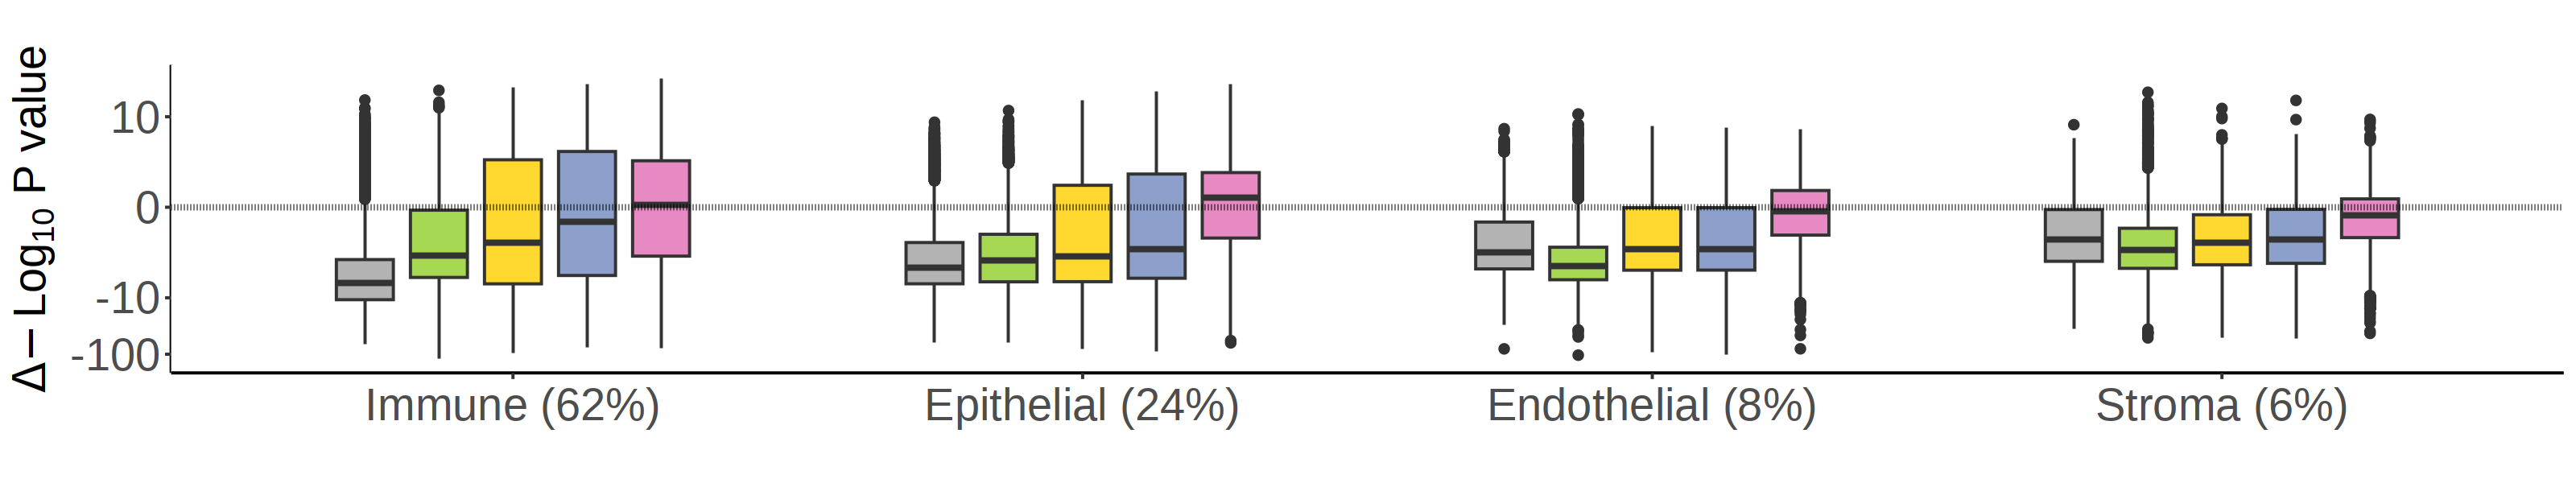

In [44]:
#figure.width  = (k) * 4
#figure.height = if (source.col == "decon.L1") 4 + 1 else 4 + 2
options(repr.plot.width = 16, repr.plot.height = 3, repr.plot.res = 200)

add.box.p  = egg::ggarrange(plots = list(add.box.g), 
                           #labels = c("c"),  
                           #label.args = list(gp = grid::gpar(font = 20, cex =3)), 
                           debug=F)

# multi

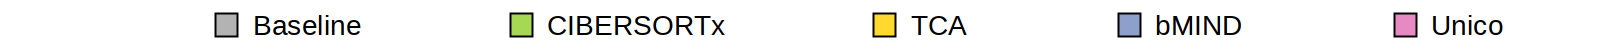

In [45]:
legend.g = as_ggplot(get_legend(covar.bar.g + 
                                theme(legend.direction = "horizontal",
                                      legend.position = c(0.575, 0.5),
                                      legend.text = element_text(size=legend.size, 
                                                                 margin = margin(r = 100, unit = "pt"))))) 


options(repr.plot.width = 16, repr.plot.height = 0.5, repr.plot.res = 100)
legend.g 

In [46]:
multi.g = ggarrange(legend.g,
                    params.bar.g, NULL,
                    cor.box.g, NULL,
                    add.box.p, 
                    nrow = 6,
                    heights = c(0.15, 1, 0.025, 2.25, 0.025, 1),
                    labels = c("", "a","", "b","", "c"),
                    font.label = list(size = 30, color = "black", face = "bold", family = NULL))

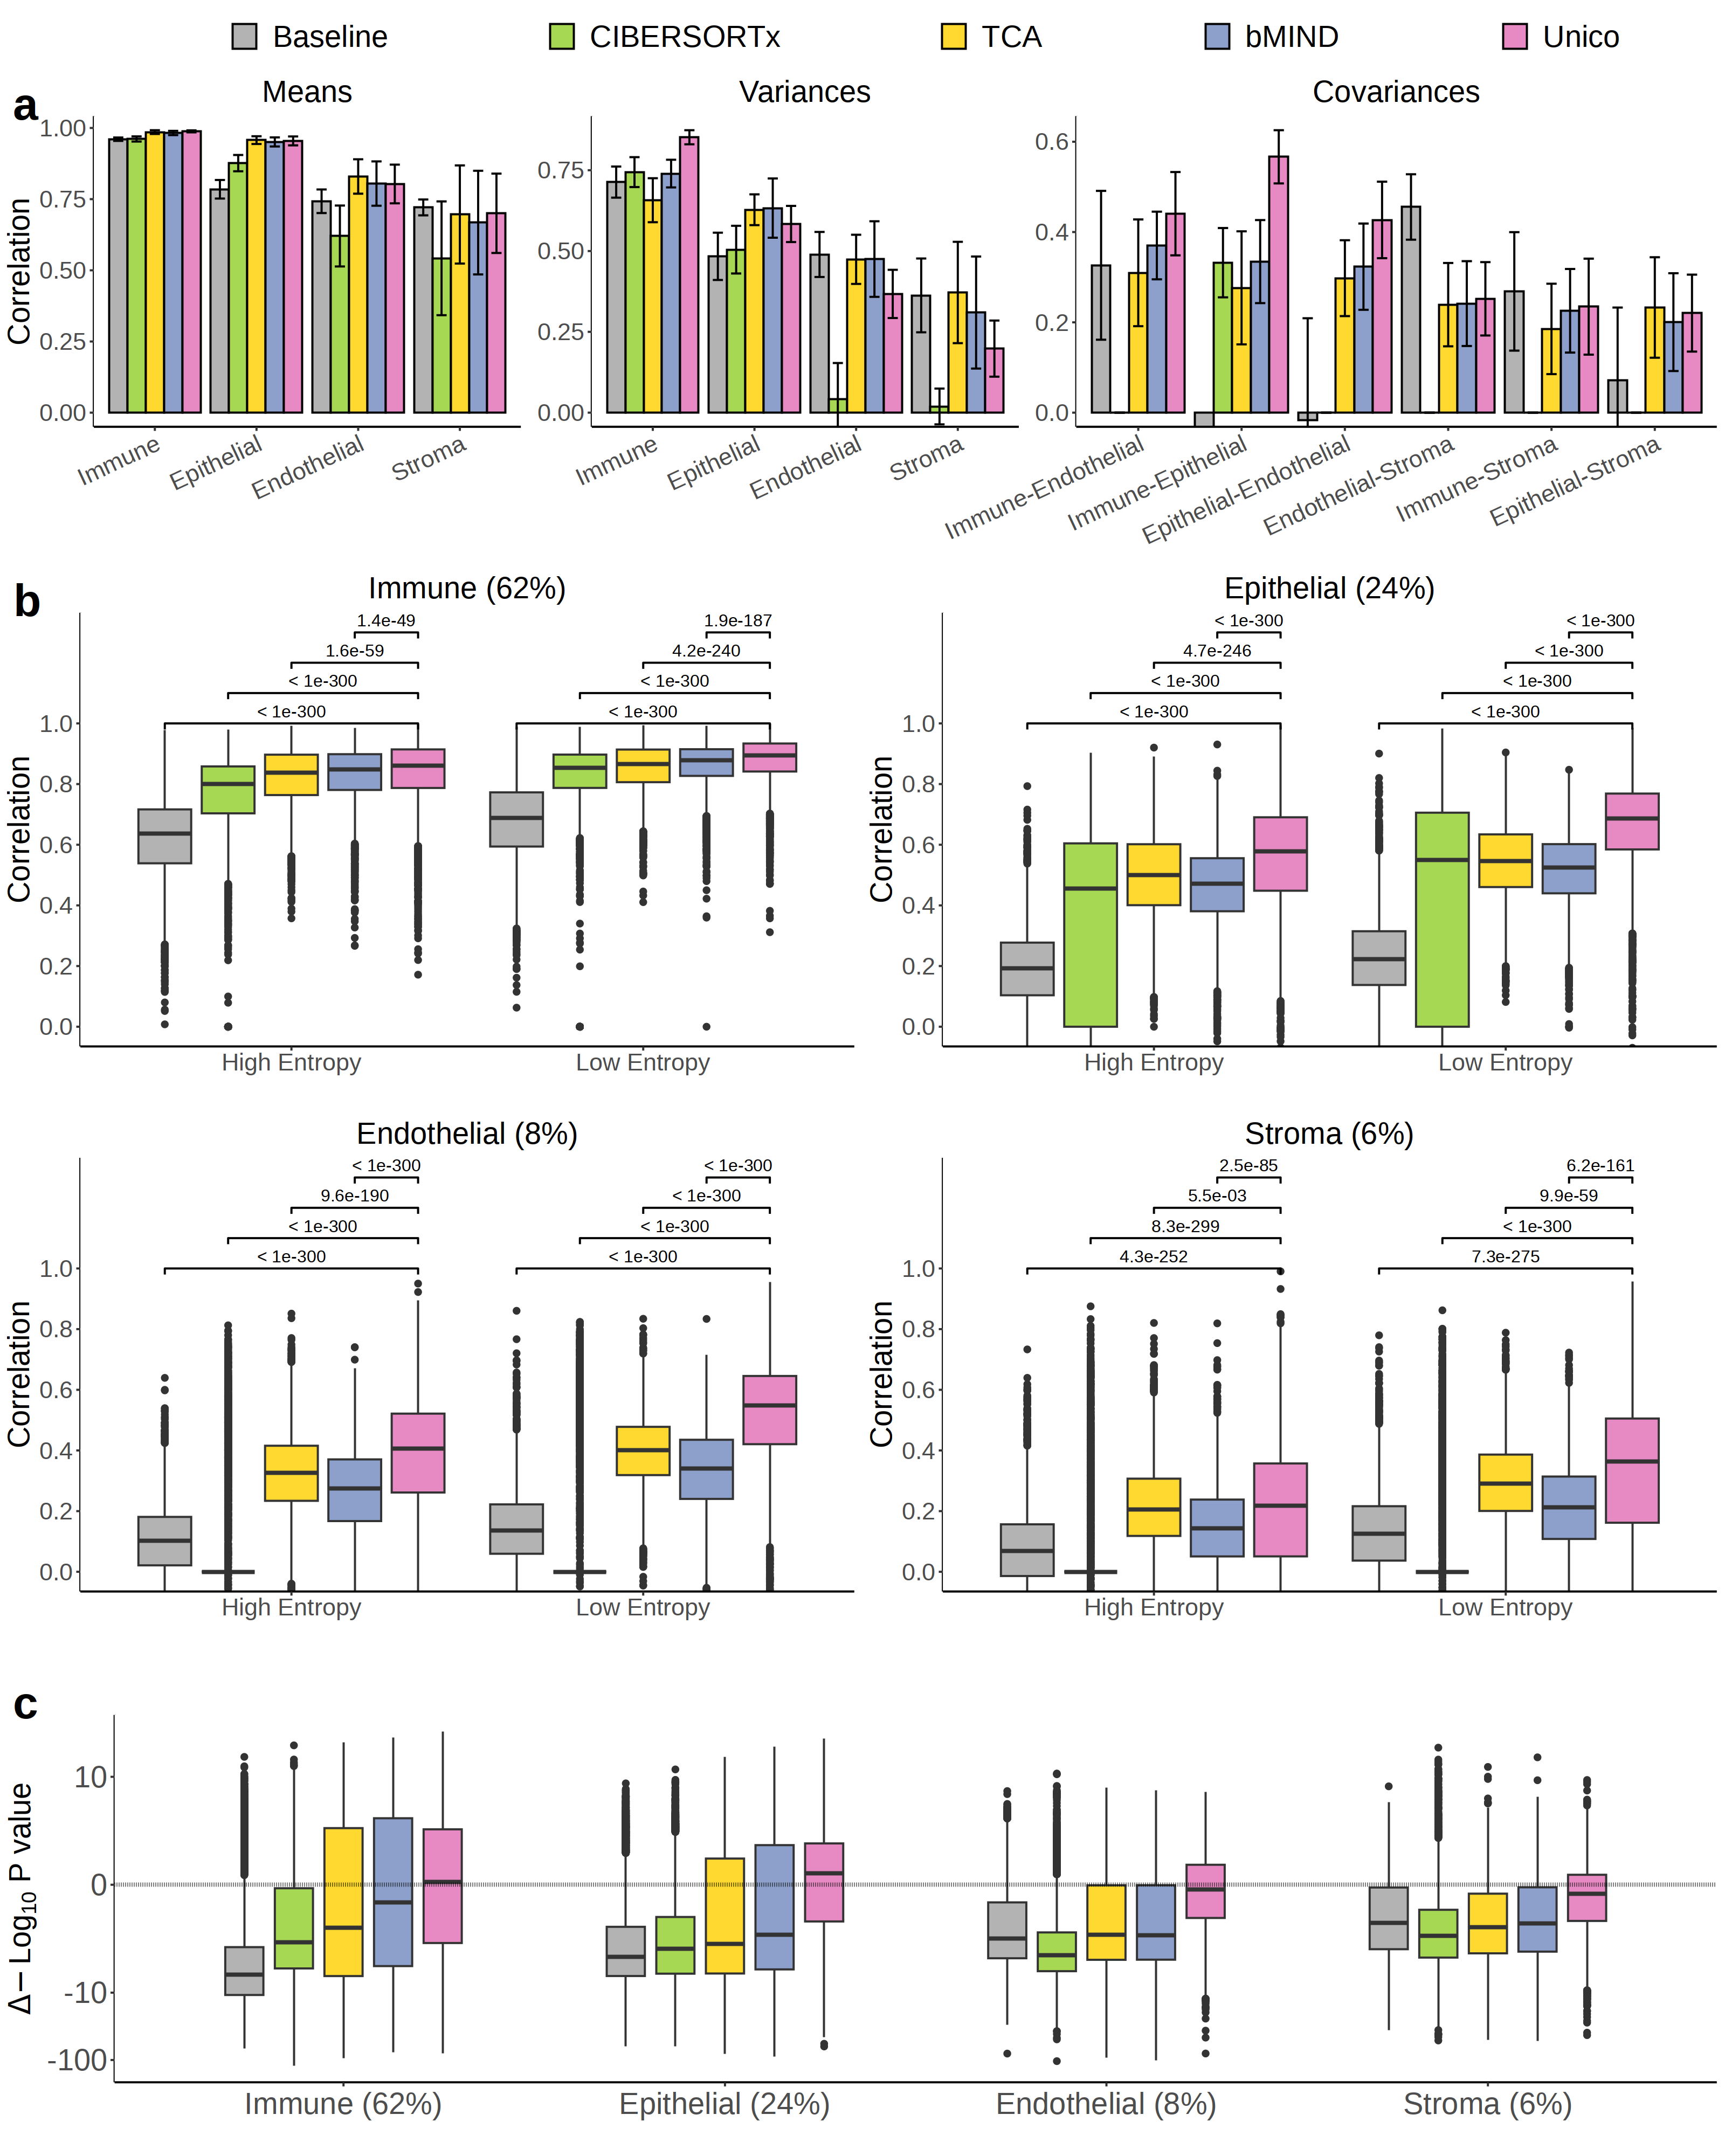

In [47]:
options(repr.plot.width = 16, repr.plot.height = 20, repr.plot.res = 200)
multi.g

In [48]:
ggsave(file.path(figure.dir, paste0("RNA_Simulation-", data.name, "_", source.col,"_", N, "_multi.pdf")), multi.g,
       device = "pdf", width = 16, height = 20, dpi = 600)

## Save related object for merged plots and for extracting summary numbers 

In [49]:
fig.list = list(legend.g = legend.g,
                mean.bar.g = mean.bar.g, 
                var.bar.g = var.bar.g, 
                covar.bar.g = covar.bar.g, 
                Z.corrs.g = plts,
                add.box.g = add.box.g)

stats.list = list(covar.barplot.df = covar.barplot.df,
                  mean.barplot.df = mean.barplot.df,
                  var.barplot.df = var.barplot.df,
                  boxplot.meta = boxplot.meta, 
                  Z.corrs.list = Z.corrs.list,
                  addition.box.dfs = addition.box.dfs)


saveRDS(fig.list,   file.path(figure.dir, paste0("RNA_Simulation-", data.name, "_", source.col,"_", N, "_fig.list.rds")))
saveRDS(stats.list, file.path(figure.dir, paste0("RNA_Simulation-", data.name, "_", source.col,"_", N, "_stats.list.rds")))

In [2]:
ggarrange(NULL, NULL, NULL, NULL, nrow = 1, 
          heights = c(1, 1, 1, 1), widths = c(1, 1, 1, 1),
          labels = c("c", "d", "e", "f"),
          font.label = list(size = 30, color = "black", face = "bold", family = NULL))

ERROR: Error in ggarrange(NULL, NULL, NULL, NULL, nrow = 1, heights = c(1, 1, : could not find function "ggarrange"


In [ ]:
ggarrange(NULL, NULL, 
                              consistency.gender.marg.g,
                              consistency.age.marg.g,
                              nrow = 3, 
                              heights = c(1.5, 0.75,  1),
                              widths =  c(1,  1, 1),
                              labels = c("a", "b"),
                              font.label = list(size = 30, color = "black", face = "bold", family = NULL)) 

# Parameters:

In [50]:
# pre tensor 
# post tensor 

# density: per gene, cor(lower tri including diag) 
# gt vs post tensor 
# gt vs pre tensor 

# insight: 
# post tensor vs pre tensor : 0.99
# 0.2, 0.3, 0.4 -> 0.99, 0.994, 0.995

# parameters: variance scatter

In [51]:
var_scatter = function(method, mdl.list, sim.data.list){
    ref = list(length(mdl.list))
    hat = list(length(mdl.list))
    k = dim(mdl.list[[1]]$"params.hat.eval"$sigmas)[2]
    m = dim(mdl.list[[1]]$"params.hat.eval"$sigmas)[1]
    source.ids = dimnames(mdl.list[[1]]$"params.hat.eval"$sigmas)[[2]]

    for (t in 1:length(mdl.list)){

        ref.mat = matrix(0, m, k)
        colnames(ref.mat) = source.ids
        hat.mat = matrix(0, m, k)
        colnames(hat.mat) = source.ids

        for (l in 1:k){
            ref.mat[,l] = sim.data.list[[t]][["params.scale"]]$sigmas[,l,l]
            hat.mat[,l] = mdl.list[[t]][["params.hat.eval"]]$sigmas[,l,l]
        }
        ref[[t]] = ref.mat
        hat[[t]] = hat.mat
    }
    ref = Reduce(rbind, ref)
    hat = Reduce(rbind, hat)

    plts <- vector(mode = "list", length = k)
    for (l in 1:k){
        source.id = source.ids[l]
        g = ggplot(data.frame(ref = ref[, source.id], 
                              hat = hat[, source.id]), aes(x = ref, y = hat))+ 
            geom_point(alpha = 0.25, size = 1) + 

            theme_classic() +
            ggtitle(paste0(method, " ", source.id, ' rob_cor: ', 
                           round(colMeans(concat_2_keys(mdl.list,       
                                                        key1 = "moment.hat.corrs", 
                                                        key2 = "var.rob.corrs"))[source.id], 
                                 3))) + 
            theme(plot.title = element_text(hjust = 0.5, size = title.size)) +
            xlab(paste0("Ground Truth Variance")) + 
            ylab(paste("Estimated Variance")) + 

            theme(text=element_text(size=lab.size))+
            coord_cartesian(ylim = c(0, quantile(hat[, source.id], c(0.95))), 
                            xlim = c(0, quantile(ref[, source.id], c(0.95))))

        plts[[l]] = g
    }
    var.scatter.g <- ggarrange(plotlist = plts, ncol = k, nrow = 1)
    return(var.scatter.g)
}

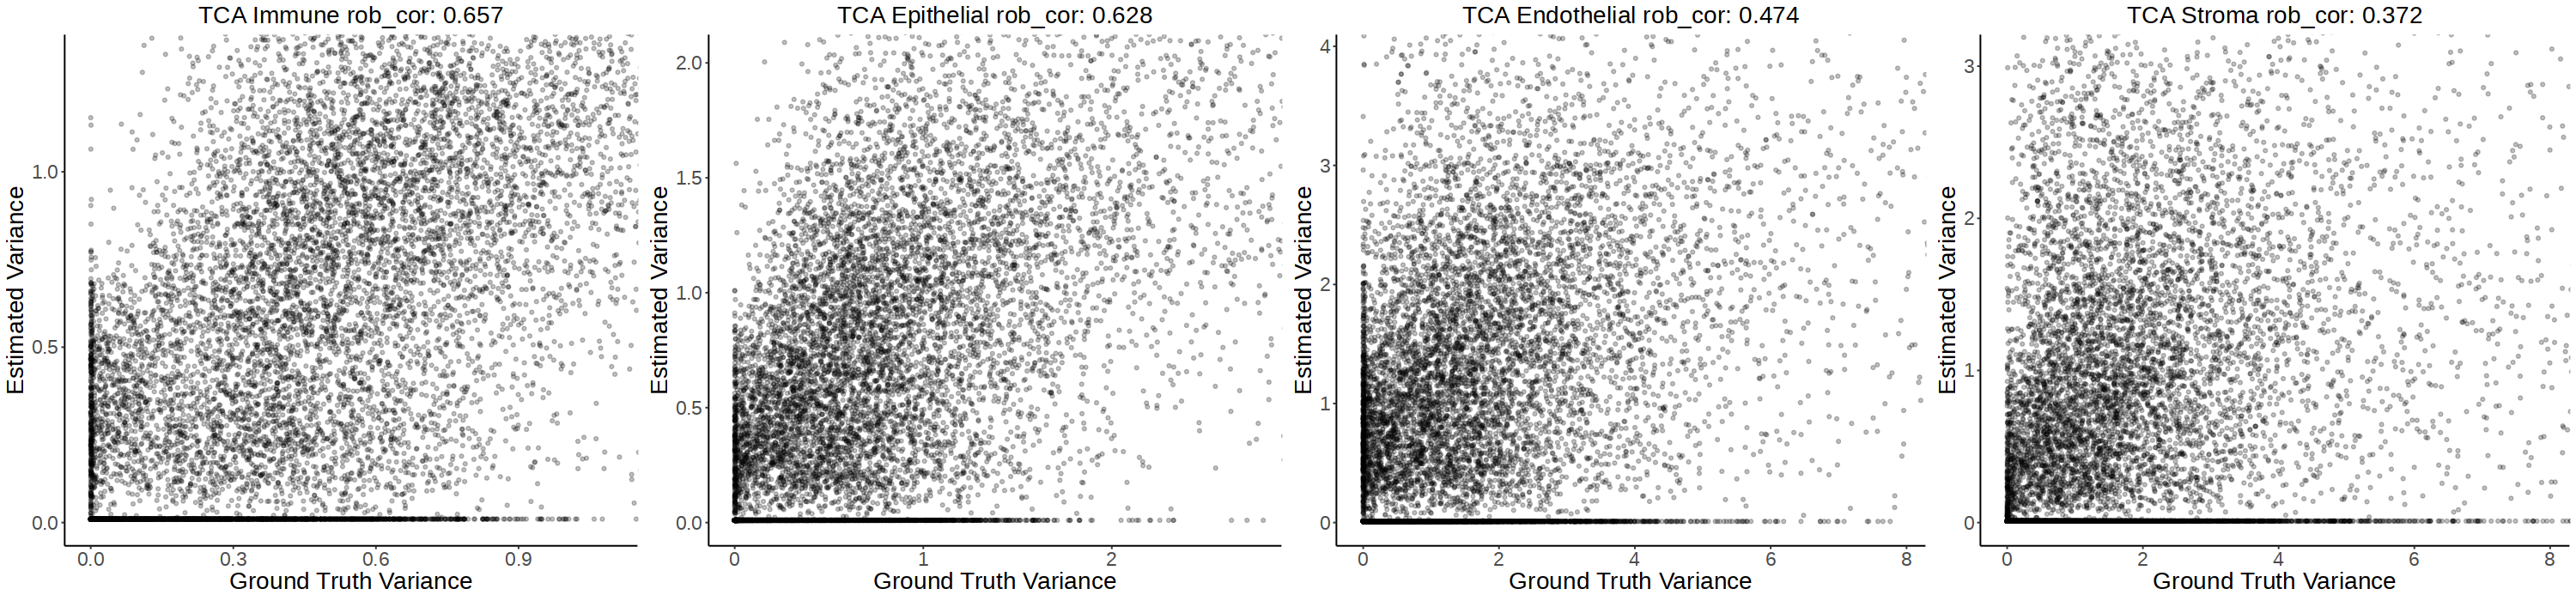

In [52]:
options(repr.plot.width = 30, repr.plot.height = 7, repr.plot.res = 100)
var_scatter(method = "TCA", mdl.list = tca.mdl.list, sim.data.list = sim.data.list)

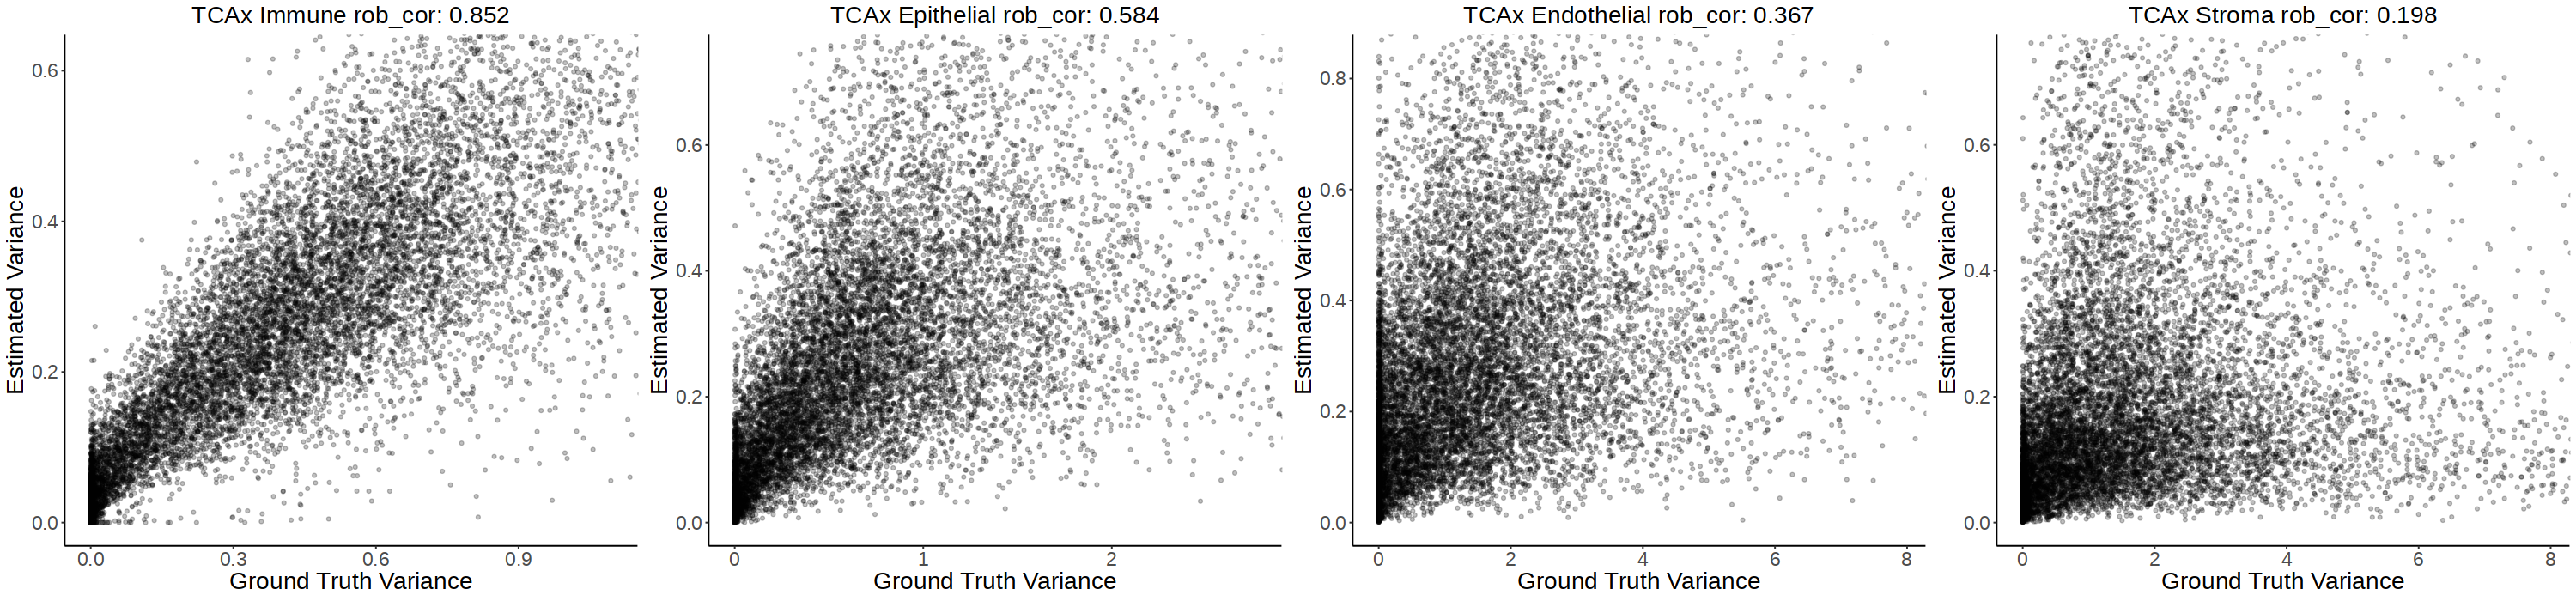

In [53]:
options(repr.plot.width = 30, repr.plot.height = 7, repr.plot.res = 100)
var_scatter(method = "TCAx", mdl.list = tcax.mdl.list, sim.data.list = sim.data.list)

# parameters: covariance scatter 